In [1]:
import numpy as np
import pandas as pd

def Ackley(x1, x2):
    term1 = -20 * np.exp(-0.2 * np.sqrt(0.5 * (x1**2 + x2**2)))
    term2 = -np.exp(0.5 * (np.cos(2 * np.pi * x1) + np.cos(2 * np.pi * x2)))
    return term1 + term2 + np.e + 20

def GetGrid(grid):
    x1 = np.linspace(-2, 2, grid)
    x2 = np.linspace(-2, 2, grid)
    x1, x2 = np.meshgrid(x1, x2)
    z = Ackley(x1, x2)
    return x1, x2, z

def create_dataframe(grid):
   x1, x2, z = GetGrid(grid)
   data = {'x1': x1.flatten(), 'x2': x2.flatten(), 'f(x1,x2)': z.flatten()}
   df = pd.DataFrame(data)
   return df


df_1000 = create_dataframe(32)
df_test = create_dataframe(grid=4)
df_training = create_dataframe(grid=5)

df_virtual = pd.read_excel("../VirtualSamples.xlsx", sheet_name="Gaussian")

/tmp/ipykernel_155808/3623673326.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


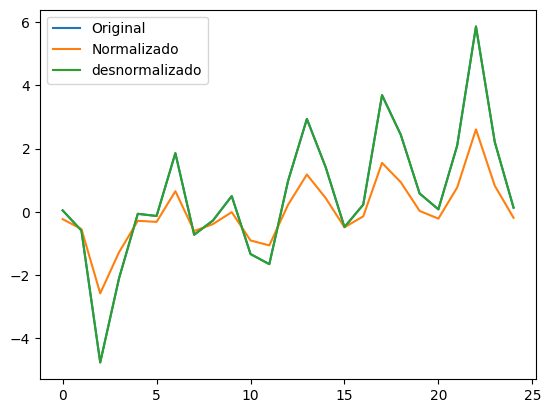

In [2]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def show_norm(df, label="data", plot=False):
    df_norm = pd.DataFrame(scaler.transform(df), columns=df.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df_norm), columns=df_norm.columns)

    if (plot):
        df.plot(title=f"{label}: Original data")
        df_norm.plot(title=f"{label}: Normalized data")
        df_denorm.plot(title=f"{label}: Denormalized data")
    return (df_norm)


def test_out_scaler(df):
    out = df["f(x1,x2)"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()

scaler.fit(df_training)
test_out_scaler(df_training)

df_training_norm = show_norm(df_training, "Training")
df_1000_norm = show_norm(df_1000)
df_test_norm = show_norm(df_test)
df_virtual_norm = show_norm(pd.concat([df_training, df_virtual]))

In [3]:
import os

os.chdir("./content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

Cloning into 'tf-levenberg-marquardt'...


remote: Enumerating objects: 53, done.
remote: Counting objects:   1% (1/53)
remote: Counting objects:   3% (2/53)
remote: Counting objects:   5% (3/53)
remote: Counting objects:   7% (4/53)
remote: Counting objects:   9% (5/53)
remote: Counting objects:  11% (6/53)
remote: Counting objects:  13% (7/53)
remote: Counting objects:  15% (8/53)
remote: Counting objects:  16% (9/53)
remote: Counting objects:  18% (10/53)
remote: Counting objects:  20% (11/53)
remote: Counting objects:  22% (12/53)
remote: Counting objects:  24% (13/53)
remote: Counting objects:  26% (14/53)
remote: Counting objects:  28% (15/53)
remote: Counting objects:  30% (16/53)
remote: Counting objects:  32% (17/53)
remote: Counting objects:  33% (18/53)
remote: Counting objects:  35% (19/53)
remote: Counting objects:  37% (20/53)
remote: Counting objects:  39% (21/53)
remote: Counting objects:  41% (22/53)
remote: Counting objects:  43% (23/53)
remote: Counting objects:  45% (24/53)
remote: Counting objects:  47% (25

In [4]:
def split_df(df):
    _input = np.vstack([df['x1'], df['x2']]).T
    _output = np.array(df['f(x1,x2)'])
    return (_input, _output)

In [5]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def compute_k(self):
        total_parameters = 0
        for layer in self.model.layers:
            weights = layer.get_weights()
            if len(weights) > 0:  
                for w in weights:
                    total_parameters += np.prod(w.shape)
        return total_parameters
        
    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer

        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
            loss=tf.keras.losses.MeanSquaredError())

        self.lm_model = lm.ModelWrapper(
            tf.keras.models.clone_model(self.model))

        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.MeanSquaredError())
        return(self.lm_model)

2024-09-09 19:10:28.762439: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-09 19:10:28.796513: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-09 19:10:28.796548: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-09 19:10:28.797437: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-09 19:10:28.803596: I tensorflow/core/platform/cpu_feature_guar

2024-09-09 19:10:32.398060: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [6]:
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error 

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
        self.k = 0

    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)
      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, tester):
      input_train, input_val, output_train, output_val = train_test_split(tester.input, tester.output, test_size=0.2, shuffle = True)

      self.dataset, self.input, self.output = self.create_dataset(tester.input, tester.output)
      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(tester.input_test, tester.output_test)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.sup_dataset, self.sup_input, self.sup_output = self.create_dataset(tester.input_1000, tester.output_1000)

      self._train = (input_train, output_train)
      self._val = (input_val, output_val)
      self._test = (tester.input_test, tester.output_test)
      self._data = (tester.input, tester.output)
      self._sup = (tester.input_1000, tester.output_1000)


    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)
      
      self.lm_model.save_weights('./initial-.weights.h5')
      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)
    
    def get_new_metrics(self, orig, pred, r2, mse):
      n = len(orig) # N: quantidade de saidas
      k = self.k
      waste = (orig.flatten() - pred.flatten())

      mape = mean_absolute_percentage_error(orig, pred)  
      r2_adj = 1 - (((n - 1)/(n - k - 1)) * (1 - r2))
      rsd = np.sqrt(np.sum(waste ** 2) / (n - 2))
      rmse = root_mean_squared_error(orig, pred)          
      aic = (-2 * np.log(mse)) + (2 * k)
      bic = (-2 * np.log(mse)) + (k * np.log(n))
      return (mape, r2_adj, rsd, rmse, aic, bic)
      

    def get_metrics(self):
          # Calculando a saida com os dados normalizados
          pred = self.lm_model.predict(self.input).flatten()
          test_pred = self.lm_model.predict(self.test_input).flatten()
          val_pred = self.lm_model.predict(self.val_input).flatten()
          sup_pred = self.lm_model.predict(self.sup_input).flatten()

          # Calculando as metricas com a saida desnormalizada
          pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
          test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
          val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
          sup_pred_denorm = out_scaler.inverse_transform(sup_pred.reshape(-1, 1))

          out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
          test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
          val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
          sup_denorm = out_scaler.inverse_transform(self._sup[1].reshape(-1, 1))

          r2 = r2_score(out_denorm, pred_denorm)
          r2_test = r2_score(test_denorm, test_pred_denorm)
          r2_val = r2_score(val_denorm, val_pred_denorm)
          r2_sup = r2_score(sup_denorm,  sup_pred_denorm)

          mse = mean_squared_error(out_denorm, pred_denorm)
          mse_test = mean_squared_error(test_denorm, test_pred_denorm)
          mse_val = mean_squared_error(val_denorm, val_pred_denorm)
          mse_sup = mean_squared_error(sup_denorm,  sup_pred_denorm)
          
          mape, r2_adj, rsd, rmse, aic, bic = self.get_new_metrics(out_denorm, pred_denorm, r2, mse)
          metrics = {
                          'r2': r2,
                          'r2_sup': r2_sup,
                          'r2_test': r2_test,
                          'r2_val': r2_val,
                          'mse': mse,
                          'mse_sup': mse_sup,
                          'mse_test': mse_test,
                          'mse_val': mse_val,
                          'mape': mape,
                          'rmse': rmse,
                          'r2_adj': r2_adj,
                          'rsd': rsd,
                          'aic': aic,
                          'bic': bic
                          }

          return metrics

In [7]:
import pickle
from itertools import product
import shutil

class Tester:
  def __init__(self, _df, _df_1000, _df_test,  run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input, self.output = split_df(_df)
    self.input_1000, self.output_1000 = split_df(_df_1000)
    self.input_test, self.output_test = split_df(_df_test)
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=2,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)
    trainer.k = shuffler.compute_k()

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"../models/{fileName}.keras"
    open(path,'w').close()
    model.save_weights(path)
    shutil.move("./initial-.weights.h5",
                f"../models/initial-weights/{fileName}.keras")

  def SaveDataset(self, trainer, fileName):
    path = f"../dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._val, trainer._test), f)
      
  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] <= boundarie): # should be >= to acsending metrics
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    return(save)

  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinacao{count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults('mse_sup', header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'../results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

# Treinando apenas com dados originais


In [8]:
tester = Tester(
                _df=df_virtual_norm,
                _df_1000=df_1000_norm,
                _df_test = df_test_norm,
                run_times=10, dataset_run_times=50)
tester.Loop(sort_by='mse',
            boundarie = 0.5,
            hidden_sizes = [[12, 2]],
            regularizers=[0.02],
            learning_rate=[0.01])

Testando combinacao1: Hidden Size=[12, 2], regularizer=0.02, learning_rate=0.01


+++++++++++ [1_0] | 1 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 34ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 70ms/step



 1/32 [..............................] - ETA: 2s


 7/32 [=====>........................] - ETA: 0s


11/32 [=========>....................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


22/32 [===================>..........] - ETA: 0s


26/32 [=======================>......] - ETA: 0s


28/32 [=========================>....] - ETA: 0s


32/32 [==============================] - 0s 12ms/step


+++++++++++ [1_0] | 2 ++++++++++++++++++


Stopped at epoch:  23

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 145ms/step



 1/32 [..............................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 4 ++++++++++++++++++


Stopped at epoch:  31

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 5 ++++++++++++++++++


Stopped at epoch: 

 6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 6 ++++++++++++++++++


Stopped at epoch:  23

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 7 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 8 ++++++++++++++++++


Stopped at epoch:  9

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 9 ++++++++++++++++++


Stopped at epoch:  17

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 10 ++++++++++++++++++


Stopped at epoch:  9

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


22/32 [===================>..........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_0_0,0.882715,0.708636,0.683232,0.830691,0.488201,1.94835,1.133062,0.634037,1.351243,0.698714,8.506223,0.709718,131.434057,272.769229


DataFrame salvo em ../results/metrics_1_0
+++++++++++ [1_1] | 1 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 2 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 3 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 5 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 7 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 8 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


26/32 [=======================>......] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 10 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_1_9,0.910880,0.742913,0.710202,0.904976,0.370966,1.719141,1.036589,0.270164,1.320484,0.609070,6.703710,0.618662,131.983288,273.318461
model_1_1_8,0.909083,0.741473,0.707881,0.903030,0.378443,1.728768,1.044892,0.275697,1.334013,0.615177,6.818661,0.624865,131.943381,273.278554
model_1_1_7,0.907227,0.740065,0.705440,0.900940,0.386171,1.738183,1.053623,0.281639,1.349992,0.621427,6.937488,0.631214,131.902949,273.238122
model_1_1_6,0.905581,0.738660,0.703938,0.898969,0.393021,1.747582,1.058997,0.287244,1.358489,0.626914,7.042809,0.636787,131.867784,273.202956
model_1_1_5,0.900768,0.725533,0.712138,0.893280,0.413054,1.835360,1.029666,0.303416,1.295666,0.642693,7.350819,0.652815,131.768354,273.103526
model_1_1_4,0.899988,0.723475,0.712654,0.891653,0.416304,1.849124,1.027821,0.308042,1.281454,0.645216,7.400786,0.655378,131.752680,273.087852
model_1_1_3,0.898403,0.721927,0.711870,0.890734,0.422901,1.859475,1.030623,0.310655,1.280763,0.650308,7.502215,0.660550,131.721236,273.056408
model_1_1_2,0.896396,0.720324,0.709733,0.888666,0.431255,1.870196,1.038267,0.316536,1.293191,0.656700,7.630665,0.667042,131.682111,273.017284
model_1_1_1,0.894388,0.718690,0.707427,0.886552,0.439615,1.881122,1.046517,0.322545,1.307709,0.663034,7.759195,0.673476,131.643714,272.978887
model_1_1_0,0.884942,0.711336,0.685920,0.881328,0.478930,1.930294,1.123444,0.337399,1.348082,0.692048,8.363685,0.702947,131.472401,272.807573


DataFrame salvo em ../results/metrics_1_1
+++++++++++ [1_2] | 1 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 2 ++++++++++++++++++

Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



 1/32 [..............................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 3 ++++++++++++++++++

Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 4 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 6 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


22/32 [===================>..........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 7 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


20/32 [=================>............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 8 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 9 ++++++++++++++++++


Stopped at epoch:  8



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_2_9,0.941865,0.759611,0.756991,0.952075,0.241988,1.607481,0.869230,0.222622,1.007424,0.491923,4.720639,0.499670,132.837731,274.172903
model_1_2_8,0.940719,0.758696,0.756268,0.951282,0.246757,1.613599,0.871816,0.226306,1.018398,0.496746,4.793955,0.504570,132.798704,274.133876
model_1_2_7,0.937282,0.756384,0.753585,0.948942,0.261064,1.629059,0.881413,0.237177,1.050356,0.510944,5.013928,0.518991,132.685981,274.021153
model_1_2_6,0.935962,0.755240,0.752660,0.947991,0.266559,1.636711,0.884721,0.241591,1.062766,0.516293,5.098412,0.524424,132.644323,273.979495
model_1_2_5,0.932335,0.752655,0.748910,0.945421,0.281659,1.653999,0.898136,0.253529,1.095580,0.530716,5.330590,0.539074,132.534114,273.869287
model_1_2_4,0.930990,0.751629,0.747827,0.944400,0.287257,1.660855,0.902007,0.258272,1.106367,0.535964,5.416658,0.544405,132.494755,273.829927
model_1_2_3,0.920509,0.743750,0.738723,0.935666,0.330884,1.713548,0.934572,0.298845,1.201867,0.575225,6.087437,0.584285,132.211973,273.547146
model_1_2_2,0.918919,0.742493,0.737418,0.934417,0.337503,1.721954,0.939241,0.304646,1.212562,0.580950,6.189196,0.590099,132.172364,273.507537
model_1_2_1,0.917217,0.741231,0.736106,0.932964,0.344586,1.730389,0.943932,0.311396,1.226499,0.587014,6.298102,0.596259,132.130824,273.465997
model_1_2_0,0.915605,0.739948,0.734970,0.931732,0.351297,1.738972,0.947999,0.317118,1.237097,0.592703,6.401283,0.602037,132.092249,273.427421


DataFrame salvo em ../results/metrics_1_2
+++++++++++ [1_3] | 1 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 2 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


21/32 [==================>...........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 5 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 6 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 6ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 8 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 9 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 10 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_3_9,0.955446,0.774321,0.755957,0.978633,0.185457,1.509119,0.872929,0.130811,0.979729,0.430647,3.851456,0.437430,133.369862,274.705035
model_1_3_8,0.955057,0.772326,0.757876,0.977463,0.187076,1.522460,0.866064,0.137977,0.964889,0.432523,3.876348,0.439335,133.352479,274.687651
model_1_3_7,0.954408,0.772165,0.757105,0.977450,0.189776,1.523530,0.868821,0.138058,0.971868,0.435633,3.917859,0.442494,133.323821,274.658994
model_1_3_6,0.953561,0.771573,0.756355,0.977170,0.193302,1.527493,0.871503,0.139769,0.981293,0.439661,3.972073,0.446586,133.287002,274.622175
model_1_3_4,0.949994,0.771253,0.752617,0.978293,0.208149,1.529631,0.884876,0.132898,0.998369,0.456234,4.200355,0.463419,133.138998,274.474170
model_1_3_5,0.952750,0.770740,0.755828,0.976780,0.196681,1.533065,0.873388,0.142159,0.985938,0.443487,4.024021,0.450471,133.252347,274.587520
model_1_3_3,0.945540,0.762194,0.760935,0.971185,0.226693,1.590208,0.855121,0.176409,0.975678,0.476123,4.485464,0.483621,132.968320,274.303492
model_1_3_2,0.944675,0.761603,0.760579,0.970707,0.230290,1.594162,0.856397,0.179339,0.982735,0.479886,4.540776,0.487443,132.936830,274.272003
model_1_3_1,0.943738,0.760833,0.759457,0.970306,0.234191,1.599311,0.860409,0.181794,0.990421,0.483932,4.600745,0.491554,132.903240,274.238413
model_1_3_0,0.942916,0.760359,0.758313,0.970054,0.237612,1.602482,0.864499,0.183335,0.998254,0.487455,4.653353,0.495132,132.874231,274.209403


DataFrame salvo em ../results/metrics_1_3


+++++++++++ [1_4] | 1 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 2 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 3 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 4 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 5 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_4] | 6 ++++++++++++++++++

Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_4] | 7 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 8 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 9 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 10 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_4_9,0.969208,0.785588,0.769553,0.945272,0.128174,1.433776,0.824297,0.103067,0.832566,0.358013,2.970705,0.363652,134.108739,275.443911
model_1_4_8,0.968567,0.785029,0.768749,0.944138,0.130839,1.437515,0.827170,0.105201,0.842089,0.361717,3.011686,0.367413,134.067575,275.402748
model_1_4_7,0.967963,0.784582,0.768305,0.942867,0.133353,1.440499,0.828759,0.107596,0.852897,0.365175,3.050341,0.370927,134.029510,275.364682
model_1_4_6,0.963332,0.780673,0.761349,0.932862,0.152630,1.466639,0.853642,0.126438,0.920272,0.390679,3.346729,0.396832,133.759477,275.094649
model_1_4_5,0.962710,0.779827,0.760704,0.931918,0.155222,1.472301,0.855947,0.128216,0.925384,0.393982,3.386574,0.400186,133.725804,275.060976
model_1_4_4,0.960457,0.777748,0.757464,0.927429,0.164600,1.486202,0.867536,0.136669,0.952837,0.405709,3.530772,0.412099,133.608473,274.943645
model_1_4_3,0.959656,0.777030,0.756509,0.926031,0.167933,1.491004,0.870951,0.139302,0.962377,0.409796,3.582013,0.416250,133.568383,274.903555
model_1_4_2,0.958862,0.776309,0.755534,0.924565,0.171239,1.495820,0.874441,0.142062,0.970945,0.413811,3.632854,0.420328,133.529385,274.864557
model_1_4_1,0.958062,0.775758,0.754532,0.923192,0.174569,1.499510,0.878026,0.144648,0.982959,0.417814,3.684040,0.424394,133.490875,274.826048
model_1_4_0,0.955960,0.775422,0.756480,0.915149,0.183320,1.501753,0.871057,0.159795,0.978608,0.428158,3.818590,0.434901,133.393048,274.728221


DataFrame salvo em ../results/metrics_1_4
+++++++++++ [1_5] | 1 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 2 ++++++++++++++++++


Stopped at epoch:  20

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 3 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



 1/32 [..............................] - ETA: 0s


11/32 [=========>....................] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_5] | 4 ++++++++++++++++++


Stopped at epoch:  9

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 6ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 29ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


23/32 [====================>.........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 8 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 9 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 10 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_5_9,0.980944,0.805005,0.778141,0.949272,0.079321,1.303930,0.793578,0.085917,0.656183,0.281640,2.219581,0.286075,135.068506,276.403679
model_1_5_8,0.980604,0.804685,0.777678,0.948473,0.080738,1.306073,0.795234,0.087272,0.661939,0.284145,2.241374,0.288620,135.033085,276.368257
model_1_5_7,0.980256,0.804379,0.777132,0.947651,0.082187,1.308122,0.797187,0.088663,0.668026,0.286682,2.263642,0.291197,134.997525,276.332697
model_1_5_6,0.979173,0.799544,0.784638,0.944667,0.086693,1.340453,0.770337,0.093717,0.679762,0.294436,2.332922,0.299073,134.890775,276.225947
model_1_5_5,0.978762,0.799213,0.783968,0.943694,0.088402,1.342661,0.772733,0.095365,0.687230,0.297325,2.359208,0.302008,134.851717,276.186890
model_1_5_4,0.978373,0.798765,0.783390,0.942816,0.090024,1.345657,0.774803,0.096852,0.692858,0.300041,2.384149,0.304766,134.815350,276.150523
model_1_5_3,0.978066,0.797912,0.782905,0.942937,0.091299,1.351362,0.776538,0.096646,0.700371,0.302157,2.403744,0.306916,134.787236,276.122408
model_1_5_2,0.976551,0.796925,0.779337,0.939918,0.097606,1.357966,0.789298,0.101759,0.733532,0.312420,2.500718,0.317340,134.653634,275.988806
model_1_5_1,0.976394,0.796408,0.779394,0.939812,0.098260,1.361420,0.789094,0.101941,0.734591,0.313465,2.510780,0.318402,134.640270,275.975442
model_1_5_0,0.969775,0.786085,0.770356,0.927814,0.125812,1.430449,0.821423,0.122260,0.823927,0.354700,2.934393,0.360286,134.145934,275.481107


DataFrame salvo em ../results/metrics_1_5
+++++++++++ [1_6] | 1 ++++++++++++++++++


Stopped at epoch:  19

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


23/32 [====================>.........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 2 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 3 ++++++++++++++++++


Stopped at epoch:  18

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


23/32 [====================>.........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 4 ++++++++++++++++++


Stopped at epoch:  22

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


23/32 [====================>.........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 5 ++++++++++++++++++


Stopped at epoch:  11

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 6 ++++++++++++++++++


Stopped at epoch:  9

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 44ms/step



 1/32 [..............................] - ETA: 0s


26/32 [=======================>......] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 7 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_6] | 9 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_6] | 10 ++++++++++++++++++


Stopped at epoch:  24

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



 1/32 [..............................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_6_9,0.995463,0.828412,0.817098,0.992452,0.018884,1.147410,0.654230,0.038196,0.274434,0.137419,1.290348,0.139584,137.938872,279.274044
model_1_6_8,0.995060,0.822361,0.813800,0.995449,0.020563,1.187872,0.666028,0.023034,0.358730,0.143397,1.316158,0.145656,137.768546,279.103719
model_1_6_6,0.994883,0.822049,0.813582,0.995352,0.021298,1.189958,0.666807,0.023524,0.366062,0.145937,1.327457,0.148236,137.698316,279.033488
model_1_6_7,0.994981,0.821997,0.813858,0.995435,0.020892,1.190306,0.665821,0.023101,0.362100,0.144542,1.321225,0.146818,137.736748,279.071920
model_1_6_5,0.994380,0.819925,0.813349,0.994910,0.023395,1.204166,0.667640,0.025760,0.386366,0.152953,1.359699,0.155362,137.510498,278.845670
model_1_6_4,0.993945,0.818665,0.811896,0.994565,0.025205,1.212588,0.672839,0.027506,0.397307,0.158760,1.387530,0.161260,137.361444,278.696616
model_1_6_3,0.992411,0.815145,0.810497,0.992456,0.031591,1.236124,0.677841,0.038178,0.416889,0.177738,1.485715,0.180537,136.909789,278.244962
model_1_6_2,0.989613,0.811626,0.801291,0.989537,0.043238,1.259660,0.710769,0.052951,0.458765,0.207938,1.664796,0.211212,136.282071,277.617243
model_1_6_1,0.984786,0.807584,0.785862,0.983105,0.063330,1.286688,0.765958,0.085503,0.517273,0.251655,1.973723,0.255619,135.518778,276.853950
model_1_6_0,0.984656,0.807437,0.785689,0.983319,0.063871,1.287670,0.766580,0.084421,0.521672,0.252727,1.982032,0.256707,135.501784,276.836957


DataFrame salvo em ../results/metrics_1_6
+++++++++++ [1_7] | 1 ++++++++++++++++++


Stopped at epoch:  11

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 2 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



 1/32 [..............................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 3 ++++++++++++++++++


Stopped at epoch:  12

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 4 ++++++++++++++++++

Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 5 ++++++++++++++++++


Stopped at epoch:  18

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


19/32 [================>.............] - ETA: 0s


27/32 [========================>.....] - ETA: 0s


32/32 [==============================] - 0s 6ms/step


+++++++++++ [1_7] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 8 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


21/32 [==================>...........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_7] | 9 ++++++++++++++++++


Stopped at epoch:  11

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 10 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_7_9,0.997830,0.828346,0.820894,0.995443,0.009031,1.147853,0.640650,0.017068,0.191254,0.095030,1.138851,0.096527,139.414231,280.749403
model_1_7_8,0.997800,0.828310,0.820955,0.995421,0.009156,1.148094,0.640433,0.017149,0.193162,0.095688,1.140780,0.097195,139.386641,280.721813
model_1_7_7,0.997501,0.828288,0.820750,0.995331,0.010404,1.148240,0.641168,0.017488,0.210335,0.101999,1.159961,0.103605,139.131170,280.466343
model_1_7_6,0.997465,0.828264,0.820775,0.995325,0.010551,1.148397,0.641078,0.017511,0.212439,0.102720,1.162229,0.104337,139.103010,280.438183
model_1_7_5,0.997213,0.828073,0.820491,0.995194,0.011599,1.149678,0.642093,0.017999,0.228923,0.107700,1.178342,0.109396,138.913623,280.248796
model_1_7_4,0.997164,0.828039,0.820521,0.995156,0.011806,1.149905,0.641984,0.018142,0.231660,0.108653,1.181514,0.110365,138.878369,280.213542
model_1_7_1,0.995994,0.827901,0.818237,0.994129,0.016673,1.150830,0.650157,0.021990,0.268481,0.129125,1.256357,0.131159,138.187888,279.523061
model_1_7_0,0.995929,0.827832,0.818248,0.994072,0.016944,1.151290,0.650117,0.022201,0.270794,0.130169,1.260517,0.132219,138.155694,279.490866
model_1_7_2,0.996199,0.827610,0.818607,0.993718,0.015820,1.152771,0.648833,0.023530,0.257434,0.125778,1.243238,0.127759,138.292952,279.628125
model_1_7_3,0.996270,0.827603,0.818658,0.993824,0.015525,1.152818,0.648651,0.023130,0.255374,0.124599,1.238701,0.126562,138.330605,279.665778


DataFrame salvo em ../results/metrics_1_7


+++++++++++ [1_8] | 1 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


23/32 [====================>.........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 2 ++++++++++++++++++


Stopped at epoch:  13

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 31ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_8] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


23/32 [====================>.........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 8 ++++++++++++++++++


Stopped at epoch:  14

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 6ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



 1/32 [..............................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_8_1,0.998002,0.829650,0.817415,0.997654,0.008317,1.139130,0.653096,0.019551,0.174152,0.091198,1.127879,0.092635,139.578869,280.914042
model_1_8_2,0.998007,0.829644,0.817361,0.997626,0.008296,1.139174,0.653291,0.019779,0.173740,0.091082,1.127553,0.092517,139.583969,280.919141
model_1_8_3,0.998024,0.829600,0.817345,0.997629,0.008227,1.139464,0.653345,0.019758,0.172982,0.090701,1.126487,0.092129,139.600746,280.935918
model_1_8_4,0.998037,0.829570,0.817480,0.997622,0.008171,1.139667,0.652862,0.019818,0.172535,0.090391,1.125625,0.091815,139.614423,280.949596
model_1_8_0,0.997864,0.828294,0.820852,0.997809,0.008893,1.148196,0.640803,0.018260,0.190368,0.094301,1.136728,0.095787,139.445039,280.780212
model_1_8_5,0.998089,0.828256,0.818954,0.997631,0.007956,1.148454,0.647590,0.019741,0.160468,0.089196,1.122325,0.090601,139.667662,281.002834
model_1_8_6,0.998272,0.828255,0.818938,0.997843,0.007191,1.148462,0.647649,0.017971,0.150556,0.084800,1.110564,0.086135,139.869851,281.205023
model_1_8_8,0.998496,0.828161,0.817279,0.997931,0.006262,1.149090,0.653583,0.017238,0.134905,0.079131,1.096276,0.080377,140.146598,281.481771
model_1_8_7,0.998425,0.827964,0.818654,0.997959,0.006555,1.150408,0.648662,0.017005,0.138289,0.080962,1.100781,0.082237,140.055125,281.390298
model_1_8_9,0.998534,0.827920,0.817138,0.997870,0.006104,1.150701,0.654088,0.017749,0.131185,0.078128,1.093850,0.079358,140.197626,281.532799


DataFrame salvo em ../results/metrics_1_8
+++++++++++ [1_9] | 1 ++++++++++++++++++


Stopped at epoch:  15

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


23/32 [====================>.........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 2 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 3 ++++++++++++++++++


Stopped at epoch:  16

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 4 ++++++++++++++++++


Stopped at epoch:  9

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_9] | 5 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


23/32 [====================>.........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 6 ++++++++++++++++++


Stopped at epoch:  14

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


22/32 [===================>..........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_9] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 8 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_9] | 9 ++++++++++++++++++

Stopped at epoch:  11

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 10 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



 1/32 [..............................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_9_0,0.998697,0.827764,0.816795,0.997835,0.005426,1.151740,0.655313,0.005723,0.127554,0.073659,1.083421,0.074819,140.433222,281.768395
model_1_9_1,0.998746,0.827471,0.815985,0.997782,0.005219,1.153704,0.658213,0.005864,0.123359,0.072242,1.080242,0.073380,140.510934,281.846107
model_1_9_9,0.999319,0.826649,0.815458,0.998481,0.002835,1.159201,0.660095,0.004016,0.109760,0.053246,1.043590,0.054084,141.731356,283.066529
model_1_9_8,0.999312,0.826559,0.815385,0.998470,0.002865,1.159799,0.660355,0.004044,0.112300,0.053528,1.044054,0.054371,141.710203,283.045376
model_1_9_2,0.998999,0.826095,0.817260,0.998303,0.004167,1.162901,0.653649,0.004487,0.102223,0.064554,1.064072,0.065571,140.961006,282.296179
model_1_9_6,0.999205,0.825994,0.816152,0.998496,0.003310,1.163579,0.657613,0.003976,0.112020,0.057531,1.050889,0.058437,141.421750,282.756923
model_1_9_7,0.999226,0.825925,0.816005,0.998467,0.003220,1.164038,0.658140,0.004052,0.113769,0.056746,1.049510,0.057640,141.476680,282.811853
model_1_9_5,0.999189,0.825819,0.816038,0.998449,0.003374,1.164747,0.658021,0.004099,0.116899,0.058090,1.051883,0.059005,141.383060,282.718232
model_1_9_4,0.999097,0.825628,0.816329,0.998495,0.003759,1.166029,0.656981,0.003978,0.110946,0.061312,1.057799,0.062278,141.167096,282.502268
model_1_9_3,0.999067,0.825548,0.816256,0.998485,0.003882,1.166558,0.657242,0.004005,0.112376,0.062305,1.059686,0.063286,141.102843,282.438015


DataFrame salvo em ../results/metrics_1_9
+++++++++++ [1_10] | 1 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 68ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 73ms/step



 1/32 [..............................] - ETA: 1s


 9/32 [=======>......................] - ETA: 0s


22/32 [===================>..........] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_10] | 2 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 50ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 3 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 4 ++++++++++++++++++


Stopped at epoch:  15

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 6 ++++++++++++++++++


Stopped at epoch:  14

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 7 ++++++++++++++++++


Stopped at epoch:  24

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 8 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 10 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_10_0,0.999348,0.826487,0.815631,0.999568,0.002713,1.160280,0.659477,0.002957,0.108663,0.052088,1.041716,0.052908,141.819271,283.154443
model_1_10_1,0.999357,0.826243,0.815644,0.999533,0.002678,1.161915,0.659431,0.003201,0.106649,0.051752,1.041179,0.052567,141.845185,283.180357
model_1_10_2,0.999372,0.825360,0.816592,0.999433,0.002614,1.167817,0.656039,0.003884,0.109947,0.051126,1.040189,0.051931,141.893860,283.229033
model_1_10_6,0.999558,0.824951,0.816424,0.999184,0.001842,1.170552,0.656641,0.005588,0.072573,0.042913,1.028314,0.043589,142.594341,283.929514
model_1_10_7,0.999558,0.824880,0.816372,0.999177,0.001839,1.171025,0.656825,0.005642,0.071107,0.042886,1.028279,0.043562,142.596823,283.931996
model_1_10_8,0.999554,0.824730,0.816060,0.999107,0.001856,1.172033,0.657941,0.006121,0.069444,0.043086,1.028542,0.043764,142.578268,283.913440
model_1_10_9,0.999555,0.824674,0.815960,0.999094,0.001852,1.172403,0.658300,0.006209,0.067906,0.043034,1.028474,0.043712,142.583049,283.918222
model_1_10_3,0.999454,0.824666,0.816659,0.999315,0.002272,1.172459,0.655799,0.004694,0.092077,0.047666,1.034933,0.048416,142.174165,283.509338
model_1_10_4,0.999457,0.824623,0.816588,0.999306,0.002260,1.172749,0.656053,0.004756,0.091334,0.047542,1.034751,0.048290,142.184606,283.519779
model_1_10_5,0.999496,0.824158,0.815875,0.999212,0.002100,1.175858,0.658606,0.005396,0.080568,0.045821,1.032281,0.046542,142.332063,283.667236


DataFrame salvo em ../results/metrics_1_10
+++++++++++ [1_11] | 1 ++++++++++++++++++


Stopped at epoch:  10

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


22/32 [===================>..........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 2 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_11] | 3 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 4 ++++++++++++++++++


Stopped at epoch:  15

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 6 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 34ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 8 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 9 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 10 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_11_5,0.999710,0.825403,0.815418,0.999833,0.001207,1.167532,0.660238,0.000508,0.054690,0.034747,1.018563,0.035294,143.438673,284.773846
model_1_11_3,0.999665,0.825253,0.815555,0.999845,0.001394,1.168531,0.659748,0.000474,0.057176,0.037331,1.021427,0.037919,143.151743,284.486916
model_1_11_9,0.999695,0.825232,0.814642,0.999536,0.001270,1.168672,0.663016,0.001416,0.064088,0.035639,1.019529,0.036201,143.337214,284.672387
model_1_11_4,0.999672,0.825230,0.815575,0.999848,0.001363,1.168686,0.659677,0.000465,0.056226,0.036923,1.020961,0.037504,143.195719,284.530891
model_1_11_8,0.999696,0.825132,0.814897,0.999617,0.001263,1.169344,0.662102,0.001169,0.062666,0.035545,1.019426,0.036105,143.347841,284.683014
model_1_11_6,0.999692,0.825088,0.814977,0.999649,0.001281,1.169634,0.661816,0.001071,0.063069,0.035795,1.019700,0.036359,143.319764,284.654937
model_1_11_7,0.999694,0.825045,0.814965,0.999633,0.001272,1.169923,0.661860,0.001119,0.063060,0.035668,1.019561,0.036230,143.333962,284.669134
model_1_11_1,0.999594,0.824970,0.815780,0.999802,0.001689,1.170427,0.658943,0.000605,0.064259,0.041099,1.025971,0.041746,142.767086,284.102259
model_1_11_2,0.999604,0.824805,0.815802,0.999823,0.001648,1.171532,0.658866,0.000541,0.062695,0.040601,1.025346,0.041241,142.815821,284.150994
model_1_11_0,0.999598,0.824782,0.816078,0.999832,0.001672,1.171685,0.657879,0.000513,0.062876,0.040889,1.025706,0.041533,142.787590,284.122763


DataFrame salvo em ../results/metrics_1_11
+++++++++++ [1_12] | 1 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 2 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 3 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 5 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 6 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 8 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 9 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 7ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_12] | 10 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 14ms/step



 1/32 [..............................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_12_9,0.999734,0.825693,0.815561,0.998644,0.001107,1.165591,0.659729,0.001580,0.075627,0.033279,1.017028,0.033803,143.611346,284.946519
model_1_12_7,0.999729,0.825651,0.815024,0.998782,0.001130,1.165873,0.661647,0.001418,0.076378,0.033613,1.017372,0.034142,143.571366,284.906539
model_1_12_3,0.999723,0.825611,0.814891,0.998930,0.001153,1.166139,0.662123,0.001246,0.073730,0.033953,1.017725,0.034488,143.531057,284.866229
model_1_12_8,0.999726,0.825606,0.815228,0.998674,0.001141,1.166173,0.660920,0.001544,0.077046,0.033772,1.017536,0.034304,143.552522,284.887694
model_1_12_4,0.999724,0.825600,0.814796,0.998888,0.001150,1.166215,0.662463,0.001295,0.073919,0.033915,1.017686,0.034450,143.535537,284.870710
model_1_12_6,0.999728,0.825595,0.814876,0.998830,0.001133,1.166245,0.662179,0.001362,0.075569,0.033659,1.017419,0.034189,143.565867,284.901040
model_1_12_2,0.999721,0.825573,0.814822,0.998961,0.001162,1.166393,0.662372,0.001210,0.073088,0.034083,1.017860,0.034619,143.515884,284.851057
model_1_12_5,0.999725,0.825571,0.814834,0.998853,0.001145,1.166411,0.662330,0.001335,0.074922,0.033841,1.017608,0.034374,143.544316,284.879489
model_1_12_1,0.999709,0.825387,0.815279,0.999212,0.001213,1.167641,0.660738,0.000918,0.066580,0.034823,1.018645,0.035372,143.429861,284.765034
model_1_12_0,0.999706,0.825372,0.815248,0.999240,0.001225,1.167737,0.660848,0.000885,0.066916,0.034995,1.018829,0.035546,143.410223,284.745396


DataFrame salvo em ../results/metrics_1_12
+++++++++++ [1_13] | 1 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 2 ++++++++++++++++++


Stopped at epoch:  31

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


22/32 [===================>..........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 3 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 4 ++++++++++++++++++


Stopped at epoch:  9

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 5 ++++++++++++++++++


Stopped at epoch:  13

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


22/32 [===================>..........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_13] | 7 ++++++++++++++++++


Stopped at epoch:  14

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


22/32 [===================>..........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_13] | 8 ++++++++++++++++++


Stopped at epoch:  11

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 29ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 9 ++++++++++++++++++


Stopped at epoch:  20

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 10 ++++++++++++++++++


Stopped at epoch:  9

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_13_9,0.999845,0.829555,0.822438,0.999505,0.000644,1.139766,0.635130,0.001837,0.059454,0.025384,1.009907,0.025784,144.694483,286.029656
model_1_13_8,0.999836,0.829518,0.822243,0.999480,0.000683,1.140015,0.635826,0.001932,0.061232,0.026142,1.010508,0.026554,144.576818,285.911991
model_1_13_7,0.999844,0.829285,0.821452,0.999621,0.000648,1.141572,0.638654,0.001409,0.057816,0.025448,1.009957,0.025849,144.684450,286.019623
model_1_13_6,0.999841,0.828928,0.820888,0.999699,0.000660,1.143961,0.640674,0.001119,0.059979,0.025695,1.010151,0.026099,144.645908,285.981081
model_1_13_5,0.999818,0.828691,0.820336,0.999661,0.000757,1.145546,0.642649,0.001259,0.065768,0.027511,1.011637,0.027944,144.372707,285.707879
model_1_13_4,0.999821,0.828670,0.820264,0.999692,0.000744,1.145687,0.642904,0.001144,0.065654,0.027282,1.011444,0.027711,144.406162,285.741334
model_1_13_3,0.999807,0.828335,0.819820,0.999733,0.000804,1.147926,0.644495,0.000990,0.067597,0.028352,1.012359,0.028798,144.252252,285.587424
model_1_13_1,0.999805,0.827919,0.818590,0.999768,0.000814,1.150709,0.648892,0.000863,0.067867,0.028527,1.012512,0.028976,144.227676,285.562848
model_1_13_2,0.999807,0.827914,0.818582,0.999772,0.000804,1.150742,0.648922,0.000845,0.068012,0.028349,1.012357,0.028796,144.252611,285.587783
model_1_13_0,0.999742,0.825788,0.815776,0.999808,0.001073,1.164956,0.658959,0.000712,0.073579,0.032759,1.016500,0.033275,143.674275,285.009447


DataFrame salvo em ../results/metrics_1_13
+++++++++++ [1_14] | 1 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 2 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 6ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 4 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


22/32 [===================>..........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_14] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


23/32 [====================>.........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_14] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 8 ++++++++++++++++++

Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_14] | 9 ++++++++++++++++++


Stopped at epoch:  8



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 14ms/step



 1/32 [..............................] - ETA: 0s


23/32 [====================>.........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 10 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_14_0,0.999846,0.829570,0.822384,0.999775,0.000641,1.139668,0.635322,0.000901,0.059585,0.025321,1.009858,0.025720,144.704424,286.039597
model_1_14_1,0.999848,0.829561,0.822392,0.999772,0.000633,1.139723,0.635293,0.000913,0.059219,0.025169,1.009740,0.025565,144.728553,286.063725
model_1_14_2,0.999854,0.829288,0.821603,0.999747,0.000606,1.141553,0.638115,0.001013,0.057208,0.024616,1.009317,0.025004,144.817394,286.152567
model_1_14_3,0.999856,0.829262,0.821569,0.999742,0.000601,1.141723,0.638239,0.001031,0.056818,0.024524,1.009247,0.024911,144.832338,286.167511
model_1_14_4,0.999857,0.829241,0.821613,0.999737,0.000597,1.141865,0.638081,0.001052,0.056065,0.024436,1.009181,0.024821,144.846719,286.181892
model_1_14_5,0.999855,0.828986,0.821620,0.999678,0.000604,1.143574,0.638057,0.001288,0.051090,0.024567,1.009280,0.024954,144.825359,286.160531
model_1_14_6,0.999855,0.828930,0.821540,0.999669,0.000605,1.143947,0.638341,0.001324,0.051267,0.024607,1.009310,0.024994,144.818916,286.154089
model_1_14_7,0.999843,0.828736,0.821426,0.999579,0.000653,1.145242,0.638749,0.001685,0.051650,0.025549,1.010036,0.025951,144.668639,286.003812
model_1_14_8,0.999814,0.828641,0.820942,0.999411,0.000776,1.145875,0.640482,0.002359,0.054085,0.027852,1.011927,0.028291,144.323421,285.658593
model_1_14_9,0.999812,0.828630,0.820927,0.999397,0.000783,1.145953,0.640533,0.002412,0.053725,0.027978,1.012036,0.028419,144.305302,285.640475


DataFrame salvo em ../results/metrics_1_14
+++++++++++ [1_15] | 1 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_15] | 2 ++++++++++++++++++


Stopped at epoch:  16

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_15] | 3 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 14ms/step



 1/32 [..............................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_15] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_15] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_15] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_15] | 7 ++++++++++++++++++


Stopped at epoch:  13

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_15] | 8 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_15] | 9 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_15] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_15_5,0.999838,0.829436,0.822770,0.999698,0.000675,1.140564,0.633943,0.001414,0.048481,0.025976,1.010374,0.026385,144.602340,285.937512
model_1_15_4,0.999838,0.829411,0.822636,0.999705,0.000675,1.140730,0.634420,0.001378,0.048992,0.025988,1.010384,0.026397,144.600463,285.935636
model_1_15_3,0.999838,0.829353,0.822460,0.999715,0.000673,1.141118,0.635050,0.001335,0.049528,0.025940,1.010346,0.026348,144.607902,285.943074
model_1_15_9,0.999814,0.829322,0.826503,0.999472,0.000773,1.141325,0.620589,0.002470,0.041180,0.027806,1.011888,0.028244,144.330001,285.665174
model_1_15_2,0.999832,0.829301,0.822730,0.999722,0.000701,1.141467,0.634086,0.001302,0.048331,0.026476,1.010778,0.026893,144.526012,285.861184
model_1_15_8,0.999814,0.829300,0.826503,0.999477,0.000774,1.141475,0.620588,0.002444,0.041579,0.027825,1.011904,0.028263,144.327258,285.662430
model_1_15_7,0.999813,0.829269,0.826434,0.999479,0.000778,1.141681,0.620835,0.002436,0.042043,0.027890,1.011959,0.028329,144.317998,285.653170
model_1_15_1,0.999830,0.829267,0.822606,0.999727,0.000706,1.141690,0.634528,0.001279,0.048910,0.026575,1.010858,0.026993,144.511183,285.846355
model_1_15_6,0.999815,0.829208,0.826305,0.999493,0.000771,1.142088,0.621298,0.002374,0.042305,0.027770,1.011857,0.028208,144.335147,285.670320
model_1_15_0,0.999819,0.828797,0.821296,0.999785,0.000755,1.144838,0.639214,0.001005,0.053108,0.027481,1.011611,0.027914,144.377060,285.712232


DataFrame salvo em ../results/metrics_1_15


+++++++++++ [1_16] | 1 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 2 ++++++++++++++++++

Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 14ms/step



 1/32 [..............................] - ETA: 0s


22/32 [===================>..........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 3 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 4 ++++++++++++++++++


Stopped at epoch:  8



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_16] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 6 ++++++++++++++++++


Stopped at epoch:  10

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 9 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_16] | 10 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_16_0,0.999817,0.829313,0.826453,0.999883,0.000763,1.141382,0.620767,0.000293,0.041115,0.027621,1.011730,0.028056,144.356683,285.691855
model_1_16_1,0.999834,0.828951,0.825640,0.999859,0.000691,1.143804,0.623675,0.000352,0.040263,0.026284,1.010622,0.026698,144.555114,285.890287
model_1_16_8,0.999862,0.828925,0.824486,0.999803,0.000573,1.143982,0.627803,0.000494,0.046832,0.023944,1.008815,0.024321,144.928138,286.263310
model_1_16_5,0.999858,0.828924,0.824519,0.999815,0.000589,1.143983,0.627685,0.000463,0.047531,0.024279,1.009063,0.024662,144.872528,286.207701
model_1_16_3,0.999846,0.828920,0.824760,0.999808,0.000640,1.144014,0.626822,0.000479,0.050516,0.025305,1.009845,0.025703,144.707092,286.042264
model_1_16_6,0.999861,0.828905,0.824426,0.999815,0.000580,1.144116,0.628019,0.000463,0.047007,0.024094,1.008925,0.024473,144.903251,286.238423
model_1_16_7,0.999862,0.828892,0.824446,0.999807,0.000576,1.144200,0.627947,0.000482,0.046654,0.023996,1.008853,0.024373,144.919549,286.254721
model_1_16_4,0.999847,0.828881,0.824617,0.999805,0.000635,1.144274,0.627333,0.000487,0.050217,0.025197,1.009762,0.025594,144.724045,286.059218
model_1_16_2,0.999840,0.828777,0.825067,0.999829,0.000667,1.144971,0.625725,0.000428,0.044423,0.025829,1.010257,0.026236,144.625042,285.960214
model_1_16_9,0.999866,0.828652,0.823341,0.999769,0.000560,1.145805,0.631901,0.000579,0.050020,0.023660,1.008607,0.024032,144.975947,286.311120


DataFrame salvo em ../results/metrics_1_16
+++++++++++ [1_17] | 1 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 2 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


23/32 [====================>.........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 8 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


23/32 [====================>.........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 9 ++++++++++++++++++


Stopped at epoch:  14

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_17_0,0.999872,0.828664,0.822733,0.999924,0.000533,1.145725,0.634073,0.000356,0.048910,0.023082,1.008192,0.023446,145.074783,286.409955
model_1_17_1,0.999875,0.828654,0.822686,0.999928,0.000521,1.145793,0.634240,0.000340,0.049652,0.022832,1.008015,0.023191,145.118455,286.453627
model_1_17_2,0.999877,0.828634,0.822563,0.999928,0.000513,1.145923,0.634681,0.000340,0.050593,0.022639,1.007880,0.022995,145.152356,286.487528
model_1_17_7,0.999848,0.828580,0.820297,0.999675,0.000635,1.146285,0.642787,0.001532,0.083774,0.025191,1.009757,0.025588,144.725021,286.060193
model_1_17_4,0.999844,0.828496,0.820797,0.999706,0.000649,1.146845,0.640999,0.001385,0.078689,0.025482,1.009984,0.025883,144.679147,286.014320
model_1_17_5,0.999841,0.828449,0.820767,0.999688,0.000661,1.147162,0.641107,0.001469,0.079649,0.025708,1.010161,0.026113,144.643849,285.979022
model_1_17_6,0.999836,0.828430,0.820635,0.999662,0.000681,1.147292,0.641578,0.001589,0.081279,0.026094,1.010469,0.026505,144.584243,285.919416
model_1_17_8,0.999852,0.828311,0.820106,0.999645,0.000616,1.148086,0.643472,0.001673,0.083612,0.024817,1.009469,0.025208,144.784907,286.120080
model_1_17_3,0.999867,0.828294,0.821758,0.999846,0.000555,1.148196,0.637561,0.000725,0.066418,0.023552,1.008528,0.023923,144.994206,286.329378
model_1_17_9,0.999844,0.828237,0.819771,0.999578,0.000651,1.148582,0.644668,0.001988,0.087279,0.025507,1.010003,0.025909,144.675191,286.010363


DataFrame salvo em ../results/metrics_1_17
+++++++++++ [1_18] | 1 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



 1/32 [..............................] - ETA: 0s


20/32 [=================>............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_18] | 2 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 3 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_18] | 4 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 6 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_18] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 8 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


21/32 [==================>...........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 10 ++++++++++++++++++


Stopped at epoch:  9

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_18_0,0.999847,0.828174,0.819736,0.999935,0.000638,1.149004,0.644794,0.000389,0.086622,0.025257,1.009808,0.025655,144.714614,286.049786
model_1_18_1,0.999850,0.828138,0.819688,0.999936,0.000626,1.149240,0.644966,0.000386,0.085871,0.025020,1.009625,0.025414,144.752390,286.087562
model_1_18_2,0.999853,0.828104,0.819648,0.999937,0.000612,1.149469,0.645107,0.000376,0.084988,0.024736,1.009408,0.025125,144.798001,286.133174
model_1_18_3,0.999855,0.828085,0.819639,0.999938,0.000602,1.149599,0.645140,0.000374,0.084289,0.024536,1.009256,0.024922,144.830527,286.165699
model_1_18_4,0.999858,0.828064,0.819619,0.999937,0.000593,1.149739,0.645212,0.000376,0.083615,0.024347,1.009114,0.024730,144.861449,286.196622
model_1_18_5,0.999860,0.828033,0.819613,0.999937,0.000584,1.149946,0.645232,0.000378,0.083018,0.024170,1.008982,0.024551,144.890528,286.225700
model_1_18_6,0.999873,0.827873,0.819354,0.999932,0.000529,1.151013,0.646159,0.000412,0.078551,0.022991,1.008127,0.023353,145.090637,286.425810
model_1_18_7,0.999874,0.827857,0.819358,0.999930,0.000522,1.151119,0.646145,0.000422,0.077887,0.022856,1.008032,0.023216,145.114097,286.449270
model_1_18_8,0.999875,0.827817,0.819310,0.999926,0.000519,1.151391,0.646319,0.000446,0.077200,0.022779,1.007978,0.023137,145.127751,286.462924
model_1_18_9,0.999882,0.827459,0.819312,0.999898,0.000492,1.153780,0.646309,0.000616,0.072432,0.022172,1.007559,0.022521,145.235651,286.570824


DataFrame salvo em ../results/metrics_1_18


+++++++++++ [1_19] | 1 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 2 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


23/32 [====================>.........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 3 ++++++++++++++++++


Stopped at epoch:  7



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 30ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 6 ++++++++++++++++++


Stopped at epoch:  9

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 32ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 9 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 42ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_19_0,0.999884,0.827598,0.819150,0.999975,0.000485,1.152850,0.646889,0.000097,0.072827,0.022013,1.007451,0.022360,145.264426,286.599599
model_1_19_1,0.999886,0.827504,0.818921,0.999979,0.000474,1.153480,0.647710,0.000084,0.072619,0.021770,1.007287,0.022113,145.308827,286.644000
model_1_19_2,0.999892,0.827189,0.818332,0.999981,0.000449,1.155585,0.649815,0.000075,0.070532,0.021197,1.006909,0.021531,145.415507,286.750680
model_1_19_9,0.999891,0.827099,0.817472,0.999713,0.000452,1.156187,0.652891,0.001119,0.046676,0.021259,1.006949,0.021594,145.403941,286.739114
model_1_19_3,0.999900,0.826835,0.817553,0.999965,0.000416,1.157955,0.652604,0.000135,0.066753,0.020392,1.006394,0.020713,145.570456,286.905629
model_1_19_5,0.999897,0.826769,0.816548,0.999877,0.000430,1.158398,0.656196,0.000478,0.065432,0.020736,1.006611,0.021062,145.503570,286.838743
model_1_19_6,0.999903,0.826718,0.816274,0.999868,0.000405,1.158741,0.657177,0.000513,0.062340,0.020127,1.006228,0.020444,145.622835,286.958007
model_1_19_7,0.999902,0.826645,0.816085,0.999857,0.000409,1.159223,0.657852,0.000556,0.062017,0.020228,1.006291,0.020546,145.602787,286.937959
model_1_19_4,0.999900,0.826635,0.816888,0.999918,0.000416,1.159294,0.654982,0.000318,0.065451,0.020387,1.006390,0.020708,145.571496,286.906668
model_1_19_8,0.999897,0.826225,0.815795,0.999780,0.000431,1.162032,0.658892,0.000856,0.058944,0.020752,1.006621,0.021079,145.500426,286.835599


DataFrame salvo em ../results/metrics_1_19
+++++++++++ [1_20] | 1 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_20] | 2 ++++++++++++++++++


Stopped at epoch:  9

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_20] | 3 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_20] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_20] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_20] | 6 ++++++++++++++++++


Stopped at epoch:  16

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_20] | 7 ++++++++++++++++++


Stopped at epoch:  10

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_20] | 8 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_20] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_20] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


23/32 [====================>.........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_20_9,0.999848,0.828096,0.817658,0.998758,0.000632,1.149524,0.652228,0.002869,0.047382,0.025144,1.009721,0.025540,144.732491,286.067663
model_1_20_8,0.999848,0.828065,0.817542,0.998754,0.000634,1.149730,0.652643,0.002877,0.047362,0.025181,1.009749,0.025578,144.726651,286.061823
model_1_20_7,0.999852,0.828027,0.817542,0.998809,0.000615,1.149984,0.652641,0.002751,0.048085,0.024798,1.009455,0.025189,144.787973,286.123146
model_1_20_6,0.999862,0.827983,0.817561,0.998917,0.000573,1.150279,0.652575,0.002501,0.050820,0.023945,1.008815,0.024322,144.928039,286.263212
model_1_20_5,0.999868,0.827894,0.817513,0.998990,0.000548,1.150877,0.652747,0.002333,0.048386,0.023412,1.008427,0.023781,145.018048,286.353220
model_1_20_4,0.999879,0.827697,0.817447,0.999124,0.000503,1.152192,0.652982,0.002023,0.052996,0.022438,1.007741,0.022792,145.187942,286.523115
model_1_20_2,0.999882,0.827633,0.817496,0.999155,0.000492,1.152619,0.652805,0.001953,0.050697,0.022178,1.007563,0.022527,145.234618,286.569791
model_1_20_3,0.999879,0.827631,0.817452,0.999130,0.000502,1.152629,0.652962,0.002009,0.051173,0.022397,1.007713,0.022750,145.195296,286.530469
model_1_20_1,0.999893,0.827520,0.817614,0.999283,0.000444,1.153372,0.652383,0.001656,0.046648,0.021060,1.006819,0.021391,145.441566,286.776739
model_1_20_0,0.999893,0.827103,0.817437,0.999316,0.000445,1.156165,0.653017,0.001580,0.046553,0.021090,1.006839,0.021422,145.435765,286.770937


DataFrame salvo em ../results/metrics_1_20
+++++++++++ [1_21] | 1 ++++++++++++++++++


Stopped at epoch:  12

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 2 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_21] | 3 ++++++++++++++++++


Stopped at epoch:  11

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 4 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 5 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 6 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 7 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 8 ++++++++++++++++++


Stopped at epoch:  12

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 9 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 10 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



 1/32 [..............................] - ETA: 0s


23/32 [====================>.........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_21_9,0.999903,0.828454,0.818904,0.999791,0.000402,1.147129,0.647768,0.000812,0.055717,0.020052,1.006182,0.020367,145.637768,286.972941
model_1_21_7,0.999889,0.828372,0.818075,0.999761,0.000462,1.147679,0.650736,0.000930,0.060677,0.021504,1.007110,0.021843,145.358026,286.693198
model_1_21_8,0.999890,0.828354,0.818109,0.999761,0.000457,1.147798,0.650612,0.000929,0.060332,0.021378,1.007027,0.021715,145.381492,286.716665
model_1_21_3,0.999879,0.827990,0.818304,0.999830,0.000505,1.150231,0.649916,0.000661,0.051727,0.022463,1.007758,0.022816,145.183602,286.518775
model_1_21_5,0.999879,0.827955,0.817926,0.999803,0.000505,1.150463,0.651267,0.000765,0.057394,0.022468,1.007762,0.022822,145.182581,286.517753
model_1_21_4,0.999878,0.827953,0.817855,0.999808,0.000509,1.150482,0.651521,0.000747,0.057248,0.022552,1.007819,0.022907,145.167808,286.502980
model_1_21_2,0.999874,0.827941,0.818131,0.999823,0.000525,1.150561,0.650533,0.000690,0.053318,0.022903,1.008065,0.023264,145.105964,286.441137
model_1_21_1,0.999858,0.827940,0.817702,0.999869,0.000593,1.150565,0.652069,0.000508,0.052824,0.024345,1.009113,0.024728,144.861703,286.196875
model_1_21_6,0.999881,0.827928,0.817841,0.999805,0.000497,1.150648,0.651574,0.000760,0.057685,0.022284,1.007635,0.022635,145.215589,286.550762
model_1_21_0,0.999852,0.827903,0.817523,0.999850,0.000618,1.150812,0.652711,0.000584,0.055525,0.024860,1.009502,0.025252,144.777939,286.113111


DataFrame salvo em ../results/metrics_1_21
+++++++++++ [1_22] | 1 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


26/32 [=======================>......] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_22] | 2 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 3 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 4 ++++++++++++++++++


Stopped at epoch:  10

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_22] | 6 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 7 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 8 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 10 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_22_9,0.999829,0.828711,0.818570,0.999620,0.000710,1.145413,0.648964,0.002688,0.065425,0.026652,1.010922,0.027072,144.499517,285.834689
model_1_22_8,0.999858,0.828678,0.818593,0.999724,0.000592,1.145628,0.648882,0.001951,0.063826,0.024337,1.009106,0.024720,144.863074,286.198247
model_1_22_7,0.999867,0.828588,0.818707,0.999754,0.000552,1.146233,0.648475,0.001744,0.062116,0.023488,1.008482,0.023858,145.005120,286.340293
model_1_22_6,0.999871,0.828575,0.818702,0.999763,0.000538,1.146319,0.648491,0.001677,0.061191,0.023202,1.008277,0.023568,145.054040,286.389213
model_1_22_5,0.999872,0.828567,0.818711,0.999769,0.000533,1.146371,0.648460,0.001633,0.061099,0.023093,1.008200,0.023457,145.072885,286.408057
model_1_22_2,0.999903,0.828515,0.818734,0.999898,0.000405,1.146723,0.648378,0.000721,0.056852,0.020121,1.006225,0.020438,145.623903,286.959076
model_1_22_4,0.999880,0.828503,0.818902,0.999815,0.000498,1.146804,0.647777,0.001310,0.061046,0.022309,1.007652,0.022660,145.211116,286.546288
model_1_22_1,0.999903,0.828498,0.818744,0.999902,0.000405,1.146838,0.648343,0.000691,0.056751,0.020117,1.006222,0.020434,145.624798,286.959970
model_1_22_3,0.999883,0.828487,0.818925,0.999826,0.000486,1.146909,0.647695,0.001231,0.061071,0.022035,1.007466,0.022383,145.260404,286.595576
model_1_22_0,0.999905,0.828472,0.818838,0.999915,0.000395,1.147010,0.648005,0.000603,0.055662,0.019868,1.006069,0.020181,145.674642,287.009815


DataFrame salvo em ../results/metrics_1_22


+++++++++++ [1_23] | 1 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_23] | 2 ++++++++++++++++++


Stopped at epoch:  11

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_23] | 3 ++++++++++++++++++


Stopped at epoch:  13

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 30ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_23] | 4 ++++++++++++++++++


Stopped at epoch:  14

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 10ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 32ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_23] | 5 ++++++++++++++++++


Stopped at epoch:  12

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


23/32 [====================>.........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_23] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 47ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



 1/32 [..............................] - ETA: 1s


15/32 [=============>................] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_23] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_23] | 8 ++++++++++++++++++


Stopped at epoch:  9

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 6ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 96ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 171ms/step



 1/32 [..............................] - ETA: 3s


 9/32 [=======>......................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


27/32 [========================>.....] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 10ms/step


+++++++++++ [1_23] | 9 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 105ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 81ms/step



 1/32 [..............................] - ETA: 1s


 5/32 [===>..........................] - ETA: 0s


12/32 [==========>...................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


26/32 [=======================>......] - ETA: 0s


32/32 [==============================] - 0s 9ms/step


+++++++++++ [1_23] | 10 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 96ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 44ms/step



 1/32 [..............................] - ETA: 1s


 8/32 [======>.......................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


21/32 [==================>...........] - ETA: 0s


27/32 [========================>.....] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 9ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_23_0,0.999828,0.828615,0.818664,0.999773,0.000715,1.146052,0.648627,0.000846,0.066119,0.026748,1.011000,0.027169,144.485155,285.820328
model_1_23_1,0.999835,0.828464,0.818418,0.999744,0.000687,1.147060,0.649510,0.000953,0.064573,0.026205,1.010559,0.026618,144.567151,285.902324
model_1_23_2,0.999845,0.828263,0.817962,0.999649,0.000647,1.148406,0.651141,0.001307,0.060763,0.025429,1.009942,0.025830,144.687436,286.022608
model_1_23_8,0.999819,0.828083,0.816298,0.999262,0.000752,1.149610,0.657092,0.002745,0.053766,0.027418,1.011559,0.027850,144.386159,285.721332
model_1_23_9,0.999818,0.828059,0.816265,0.999252,0.000756,1.149768,0.657208,0.002783,0.053661,0.027499,1.011627,0.027932,144.374428,285.709600
model_1_23_3,0.999845,0.828055,0.817085,0.999535,0.000643,1.149798,0.654278,0.001731,0.058782,0.025363,1.009890,0.025762,144.697911,286.033084
model_1_23_6,0.999826,0.827963,0.816509,0.999350,0.000722,1.150414,0.656338,0.002419,0.056763,0.026878,1.011107,0.027301,144.465826,285.800999
model_1_23_4,0.999834,0.827954,0.816508,0.999402,0.000691,1.150472,0.656342,0.002224,0.057349,0.026289,1.010626,0.026703,144.554406,285.889578
model_1_23_5,0.999833,0.827939,0.816468,0.999392,0.000694,1.150574,0.656484,0.002263,0.056966,0.026351,1.010676,0.026766,144.545058,285.880230
model_1_23_7,0.999820,0.827938,0.816032,0.999272,0.000751,1.150580,0.658043,0.002711,0.055181,0.027402,1.011545,0.027833,144.388569,285.723741


DataFrame salvo em ../results/metrics_1_23
+++++++++++ [1_24] | 1 ++++++++++++++++++


2024-09-09 19:13:26.407939: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  21



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_24] | 2 ++++++++++++++++++


Stopped at epoch:  11

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



 1/32 [..............................] - ETA: 1s


11/32 [=========>....................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_24] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_24] | 4 ++++++++++++++++++


Stopped at epoch:  32

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 7ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_24] | 5 ++++++++++++++++++


Stopped at epoch:  36

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_24] | 6 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 41ms/step



 1/32 [..............................] - ETA: 0s


23/32 [====================>.........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_24] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_24] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_24] | 9 ++++++++++++++++++


Stopped at epoch:  18

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


 8/32 [======>.......................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


23/32 [====================>.........] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 7ms/step


+++++++++++ [1_24] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


27/32 [========================>.....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_24_9,0.999877,0.829203,0.821939,0.999644,0.000514,1.142119,0.636915,0.002036,0.051789,0.022663,1.007897,0.023020,145.148104,286.483276
model_1_24_8,0.999879,0.829202,0.821908,0.999653,0.000505,1.142128,0.637023,0.001986,0.051541,0.022463,1.007758,0.022817,145.183502,286.518674
model_1_24_7,0.999890,0.829130,0.821353,0.999729,0.000456,1.142607,0.639011,0.001551,0.052929,0.021356,1.007012,0.021692,145.385693,286.720866
model_1_24_6,0.999891,0.829112,0.821371,0.999732,0.000454,1.142726,0.638947,0.001534,0.052533,0.021306,1.006979,0.021641,145.395102,286.730274
model_1_24_5,0.999892,0.829107,0.821339,0.999738,0.000449,1.142760,0.639062,0.001498,0.052641,0.021197,1.006908,0.021531,145.415633,286.750805
model_1_24_4,0.999894,0.829074,0.821229,0.999749,0.000442,1.142984,0.639455,0.001436,0.052829,0.021015,1.006790,0.021346,145.450147,286.785319
model_1_24_3,0.999894,0.828777,0.819727,0.999855,0.000443,1.144969,0.644824,0.000829,0.052893,0.021053,1.006815,0.021385,145.442851,286.778024
model_1_24_2,0.999861,0.828413,0.817862,0.999887,0.000580,1.147404,0.651498,0.000644,0.052936,0.024083,1.008917,0.024462,144.905025,286.240198
model_1_24_1,0.999860,0.828359,0.817853,0.999890,0.000582,1.147767,0.651529,0.000626,0.052325,0.024118,1.008943,0.024497,144.899252,286.234424
model_1_24_0,0.999851,0.828251,0.817504,0.999903,0.000621,1.148488,0.652778,0.000557,0.052624,0.024921,1.009549,0.025314,144.768129,286.103302


DataFrame salvo em ../results/metrics_1_24
+++++++++++ [1_25] | 1 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_25] | 2 ++++++++++++++++++


Stopped at epoch:  42

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_25] | 3 ++++++++++++++++++


Stopped at epoch:  30

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_25] | 4 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 44ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 34ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


28/32 [=========================>....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_25] | 5 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


11/32 [=========>....................] - ETA: 0s


28/32 [=========================>....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_25] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 60ms/step



 1/32 [..............................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 7 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 6ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_25] | 8 ++++++++++++++++++


Stopped at epoch:  11

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 40ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 29ms/step



 1/32 [..............................] - ETA: 1s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_25] | 9 ++++++++++++++++++


Stopped at epoch:  17

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_25] | 10 ++++++++++++++++++


Stopped at epoch:  9

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_25_9,0.999791,0.830495,0.824088,0.998774,0.000870,1.133480,0.629227,0.004021,0.087905,0.029502,1.013382,0.029967,144.093156,285.428329
model_1_25_8,0.999793,0.830477,0.824029,0.998805,0.000862,1.133602,0.629439,0.003917,0.088919,0.029352,1.013246,0.029814,144.113569,285.448741
model_1_25_7,0.999818,0.830399,0.823079,0.998994,0.000757,1.134125,0.632836,0.003299,0.083878,0.027522,1.011646,0.027955,144.371114,285.706287
model_1_25_6,0.999865,0.830304,0.823210,0.999318,0.000564,1.134758,0.632368,0.002235,0.072379,0.023749,1.008672,0.024123,144.960875,286.296047
model_1_25_5,0.999870,0.830287,0.823222,0.999364,0.000540,1.134870,0.632323,0.002086,0.071011,0.023232,1.008299,0.023598,145.048855,286.384028
model_1_25_2,0.999869,0.830268,0.823018,0.999394,0.000546,1.135002,0.633054,0.001987,0.073625,0.023367,1.008395,0.023735,145.025688,286.360860
model_1_25_1,0.999873,0.830230,0.822440,0.999532,0.000527,1.135250,0.635123,0.001533,0.074864,0.022960,1.008105,0.023322,145.096005,286.431177
model_1_25_4,0.999873,0.830216,0.823124,0.999382,0.000530,1.135345,0.632674,0.002027,0.070679,0.023021,1.008148,0.023383,145.085414,286.420587
model_1_25_3,0.999876,0.830195,0.823130,0.999411,0.000518,1.135486,0.632655,0.001933,0.070132,0.022760,1.007965,0.023119,145.130978,286.466151
model_1_25_0,0.999871,0.829237,0.822188,0.999847,0.000537,1.141890,0.636023,0.000501,0.051394,0.023169,1.008253,0.023534,145.059821,286.394994


DataFrame salvo em ../results/metrics_1_25


+++++++++++ [1_26] | 1 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


28/32 [=========================>....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_26] | 2 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_26] | 3 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_26] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_26] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 67ms/step



 1/32 [..............................] - ETA: 1s


12/32 [==========>...................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


20/32 [=================>............] - ETA: 0s


23/32 [====================>.........] - ETA: 0s


28/32 [=========================>....] - ETA: 0s


32/32 [==============================] - 0s 12ms/step


+++++++++++ [1_26] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 6ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



 1/32 [..............................] - ETA: 0s


11/32 [=========>....................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 6ms/step


+++++++++++ [1_26] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


 8/32 [======>.......................] - ETA: 0s


20/32 [=================>............] - ETA: 0s


32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_26] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


13/32 [===========>..................] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_26] | 9 ++++++++++++++++++


Stopped at epoch:  9

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 39ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_26] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 45ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


27/32 [========================>.....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_26_0,0.999800,0.830542,0.823572,0.999726,0.000832,1.133168,0.631073,0.001529,0.085614,0.028852,1.012799,0.029307,144.182268,285.517440
model_1_26_1,0.999805,0.830440,0.823386,0.999738,0.000813,1.133848,0.631738,0.001461,0.084051,0.028515,1.012502,0.028964,144.229327,285.564499
model_1_26_8,0.999857,0.830434,0.822657,0.999785,0.000594,1.133885,0.634345,0.001202,0.081825,0.024379,1.009138,0.024763,144.856110,286.191283
model_1_26_4,0.999834,0.830363,0.822548,0.999769,0.000690,1.134362,0.634734,0.001288,0.087104,0.026272,1.010612,0.026686,144.556972,285.892144
model_1_26_5,0.999836,0.830339,0.822593,0.999773,0.000682,1.134523,0.634575,0.001264,0.086423,0.026107,1.010479,0.026518,144.582256,285.917429
model_1_26_2,0.999817,0.830329,0.823633,0.999720,0.000760,1.134591,0.630853,0.001564,0.087150,0.027562,1.011680,0.027996,144.365266,285.700439
model_1_26_3,0.999820,0.830305,0.823735,0.999721,0.000751,1.134752,0.630488,0.001558,0.086722,0.027396,1.011540,0.027828,144.389367,285.724540
model_1_26_7,0.999850,0.830263,0.823782,0.999775,0.000624,1.135032,0.630321,0.001255,0.083878,0.024981,1.009595,0.025374,144.758590,286.093762
model_1_26_6,0.999835,0.830057,0.823699,0.999762,0.000688,1.136408,0.630617,0.001329,0.088062,0.026227,1.010576,0.026640,144.563887,285.899059
model_1_26_9,0.999864,0.829687,0.823566,0.999791,0.000568,1.138882,0.631096,0.001164,0.076517,0.023833,1.008733,0.024208,144.946768,286.281940


DataFrame salvo em ../results/metrics_1_26


+++++++++++ [1_27] | 1 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_27] | 2 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_27] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


23/32 [====================>.........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 4 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_27] | 5 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_27] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 6ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 31ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_27] | 7 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 6ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 31ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_27] | 8 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 64ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


22/32 [===================>..........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_27_1,0.999872,0.829422,0.823641,0.999920,0.000535,1.140657,0.630825,0.000475,0.072340,0.023121,1.008219,0.023485,145.068111,286.403284
model_1_27_0,0.999870,0.829379,0.823650,0.999920,0.000542,1.140945,0.630795,0.000472,0.072318,0.023274,1.008329,0.023641,145.041629,286.376802
model_1_27_2,0.999879,0.829249,0.823589,0.999906,0.000504,1.141814,0.631011,0.000558,0.069967,0.022453,1.007751,0.022807,145.185325,286.520498
model_1_27_3,0.999879,0.828956,0.823617,0.999881,0.000503,1.143772,0.630912,0.000704,0.069666,0.022426,1.007732,0.022779,145.190178,286.525350
model_1_27_4,0.999883,0.828808,0.823611,0.999861,0.000486,1.144759,0.630932,0.000824,0.066014,0.022039,1.007468,0.022387,145.259687,286.594859
model_1_27_5,0.999884,0.828615,0.823361,0.999834,0.000482,1.146052,0.631826,0.000979,0.063418,0.021959,1.007414,0.022304,145.274387,286.609559
model_1_27_6,0.999879,0.828460,0.823145,0.999814,0.000505,1.147086,0.632602,0.001098,0.065324,0.022468,1.007762,0.022822,145.182631,286.517803
model_1_27_7,0.999864,0.828216,0.823236,0.999760,0.000565,1.148720,0.632275,0.001419,0.067757,0.023769,1.008686,0.024143,144.957513,286.292685
model_1_27_8,0.999865,0.828190,0.823146,0.999760,0.000560,1.148895,0.632595,0.001420,0.067511,0.023668,1.008613,0.024041,144.974529,286.309701
model_1_27_9,0.999862,0.828161,0.823112,0.999747,0.000573,1.149089,0.632719,0.001497,0.067684,0.023930,1.008805,0.024307,144.930468,286.265640


DataFrame salvo em ../results/metrics_1_27


+++++++++++ [1_28] | 1 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 29ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_28] | 2 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_28] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 41ms/step



 1/32 [..............................] - ETA: 0s


11/32 [=========>....................] - ETA: 0s


23/32 [====================>.........] - ETA: 0s


32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_28] | 4 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 34ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_28] | 5 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_28] | 6 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_28] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_28] | 8 ++++++++++++++++++


Stopped at epoch:  15

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 54ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_28] | 9 ++++++++++++++++++


Stopped at epoch:  15

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_28] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 35ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_28_4,0.999894,0.828232,0.821949,0.999673,0.000443,1.148611,0.636879,0.000481,0.057391,0.021044,1.006809,0.021376,145.444466,286.779639
model_1_28_2,0.999875,0.828206,0.822708,0.999682,0.000519,1.148788,0.634165,0.000468,0.062704,0.022788,1.007984,0.023147,145.126093,286.461266
model_1_28_5,0.999896,0.828190,0.821834,0.999677,0.000432,1.148896,0.637288,0.000475,0.055957,0.020793,1.006648,0.021121,145.492539,286.827712
model_1_28_6,0.999897,0.828152,0.821721,0.999676,0.000428,1.149150,0.637692,0.000477,0.055900,0.020694,1.006584,0.021020,145.511670,286.846843
model_1_28_7,0.999905,0.828117,0.821404,0.999576,0.000395,1.149384,0.638827,0.000624,0.052670,0.019876,1.006074,0.020189,145.672899,287.008072
model_1_28_3,0.999893,0.828117,0.821994,0.999692,0.000445,1.149385,0.636716,0.000453,0.058726,0.021087,1.006837,0.021419,145.436333,286.771505
model_1_28_1,0.999865,0.828112,0.823061,0.999679,0.000561,1.149419,0.632902,0.000472,0.063618,0.023685,1.008625,0.024058,144.971609,286.306781
model_1_28_8,0.999913,0.828090,0.821189,0.999473,0.000361,1.149562,0.639596,0.000775,0.048270,0.019001,1.005551,0.019300,145.853003,287.188176
model_1_28_0,0.999864,0.828070,0.823059,0.999686,0.000565,1.149695,0.632909,0.000462,0.063842,0.023764,1.008683,0.024138,144.958355,286.293527
model_1_28_9,0.999915,0.828067,0.821165,0.999417,0.000356,1.149720,0.639682,0.000857,0.047856,0.018858,1.005468,0.019155,145.883218,287.218391


DataFrame salvo em ../results/metrics_1_28
+++++++++++ [1_29] | 1 ++++++++++++++++++


Stopped at epoch:  9

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 6ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_29] | 2 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


28/32 [=========================>....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_29] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 33ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 64ms/step



 1/32 [..............................] - ETA: 1s


15/32 [=============>................] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_29] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_29] | 5 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_29] | 6 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 29ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 1s


15/32 [=============>................] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_29] | 7 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_29] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


28/32 [=========================>....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_29] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_29] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 29ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_29_6,0.999918,0.828297,0.821248,0.999176,0.000339,1.148180,0.639386,0.000845,0.044215,0.018420,1.005217,0.018710,145.977302,287.312474
model_1_29_5,0.999919,0.828292,0.821294,0.999225,0.000338,1.148211,0.639220,0.000795,0.045362,0.018389,1.005199,0.018679,145.983955,287.319127
model_1_29_9,0.999916,0.828286,0.821346,0.999099,0.000349,1.148255,0.639034,0.000925,0.047470,0.018684,1.005368,0.018979,145.920272,287.255445
model_1_29_8,0.999916,0.828262,0.821350,0.999113,0.000349,1.148415,0.639022,0.000911,0.047290,0.018682,1.005366,0.018976,145.920794,287.255966
model_1_29_7,0.999916,0.828261,0.821351,0.999124,0.000350,1.148419,0.639016,0.000899,0.046836,0.018702,1.005378,0.018997,145.916426,287.251598
model_1_29_4,0.999921,0.828219,0.821282,0.999320,0.000330,1.148700,0.639263,0.000698,0.044048,0.018173,1.005078,0.018459,146.031237,287.366410
model_1_29_3,0.999918,0.828171,0.821263,0.999330,0.000339,1.149018,0.639330,0.000688,0.047161,0.018424,1.005219,0.018714,145.976439,287.311611
model_1_29_2,0.999918,0.828171,0.821272,0.999342,0.000340,1.149019,0.639298,0.000676,0.046942,0.018446,1.005231,0.018736,145.971715,287.306888
model_1_29_1,0.999918,0.828155,0.821261,0.999350,0.000342,1.149128,0.639340,0.000667,0.046132,0.018491,1.005257,0.018782,145.961937,287.297110
model_1_29_0,0.999918,0.828140,0.821203,0.999377,0.000339,1.149226,0.639548,0.000640,0.044611,0.018424,1.005219,0.018714,145.976513,287.311685


DataFrame salvo em ../results/metrics_1_29


+++++++++++ [1_30] | 1 ++++++++++++++++++


Stopped at epoch:  10

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_30] | 2 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_30] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 61ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 44ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


28/32 [=========================>....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_30] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_30] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 8ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



 1/32 [..............................] - ETA: 0s


23/32 [====================>.........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_30] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_30] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


23/32 [====================>.........] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_30] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 30ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


28/32 [=========================>....] - ETA: 0s


32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_30] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_30_3,0.999911,0.828252,0.820212,0.999897,0.000373,1.148477,0.643093,0.000699,0.048251,0.019301,1.005728,0.019605,145.790458,287.125631
model_1_30_4,0.999909,0.828235,0.820052,0.999889,0.000380,1.148593,0.643664,0.000756,0.048531,0.019488,1.005839,0.019795,145.751852,287.087024
model_1_30_2,0.999916,0.828228,0.820876,0.999939,0.000348,1.148638,0.640715,0.000417,0.049814,0.018653,1.005350,0.018947,145.926910,287.262083
model_1_30_1,0.999919,0.828211,0.821374,0.999969,0.000338,1.148754,0.638935,0.000212,0.047598,0.018398,1.005204,0.018688,145.982106,287.317278
model_1_30_0,0.999918,0.828185,0.821428,0.999970,0.000341,1.148925,0.638743,0.000202,0.047348,0.018473,1.005247,0.018764,145.965769,287.300942
model_1_30_5,0.999896,0.828152,0.819692,0.999844,0.000431,1.149150,0.644951,0.001066,0.050781,0.020764,1.006629,0.021091,145.498073,286.833246
model_1_30_9,0.999880,0.828093,0.818179,0.999745,0.000499,1.149546,0.650364,0.001738,0.048233,0.022337,1.007671,0.022688,145.206097,286.541269
model_1_30_6,0.999892,0.828028,0.819330,0.999814,0.000447,1.149979,0.646248,0.001265,0.049142,0.021154,1.006880,0.021487,145.423771,286.758943
model_1_30_7,0.999891,0.828017,0.818963,0.999796,0.000454,1.150053,0.647558,0.001388,0.047874,0.021296,1.006973,0.021632,145.396872,286.732044
model_1_30_8,0.999883,0.827974,0.818396,0.999763,0.000488,1.150341,0.649588,0.001615,0.047762,0.022090,1.007502,0.022437,145.250599,286.585772


DataFrame salvo em ../results/metrics_1_30


+++++++++++ [1_31] | 1 ++++++++++++++++++


Stopped at epoch:  11

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 6ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 29ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_31] | 2 ++++++++++++++++++


Stopped at epoch:  51

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_31] | 3 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_31] | 4 ++++++++++++++++++


Stopped at epoch:  14

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


11/32 [=========>....................] - ETA: 0s


20/32 [=================>............] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_31] | 5 ++++++++++++++++++


Stopped at epoch:  11

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



 1/32 [..............................] - ETA: 1s


10/32 [========>.....................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_31] | 6 ++++++++++++++++++


Stopped at epoch:  15

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 6ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


21/32 [==================>...........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_31] | 7 ++++++++++++++++++


Stopped at epoch:  13

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_31] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 11ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_31] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_31] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_31_4,0.999925,0.828804,0.818680,0.999718,0.000313,1.144791,0.648573,0.001080,0.050811,0.017695,1.004814,0.017974,146.137807,287.472979
model_1_31_3,0.999926,0.828665,0.818686,0.999756,0.000306,1.145721,0.648548,0.000934,0.050769,0.017506,1.004712,0.017782,146.180735,287.515908
model_1_31_5,0.999928,0.828569,0.818672,0.999718,0.000299,1.146357,0.648598,0.001083,0.050752,0.017305,1.004604,0.017578,146.227013,287.562185
model_1_31_7,0.999923,0.828569,0.818829,0.999673,0.000322,1.146359,0.648037,0.001254,0.049836,0.017958,1.004958,0.018240,146.078977,287.414150
model_1_31_6,0.999924,0.828525,0.818813,0.999682,0.000318,1.146654,0.648097,0.001220,0.049888,0.017821,1.004883,0.018102,146.109513,287.444685
model_1_31_8,0.999923,0.828508,0.818873,0.999672,0.000322,1.146768,0.647879,0.001257,0.049487,0.017946,1.004952,0.018229,146.081513,287.416685
model_1_31_2,0.999924,0.828507,0.818439,0.999775,0.000316,1.146773,0.649432,0.000863,0.052298,0.017765,1.004852,0.018045,146.122054,287.457226
model_1_31_1,0.999924,0.828479,0.818396,0.999779,0.000316,1.146959,0.649588,0.000847,0.053146,0.017779,1.004860,0.018059,146.118964,287.454137
model_1_31_9,0.999922,0.828477,0.818996,0.999669,0.000323,1.146973,0.647441,0.001270,0.048998,0.017972,1.004966,0.018255,146.075816,287.410988
model_1_31_0,0.999884,0.828302,0.818084,0.999810,0.000483,1.148144,0.650703,0.000727,0.052273,0.021983,1.007430,0.022329,145.269917,286.605089


DataFrame salvo em ../results/metrics_1_31
+++++++++++ [1_32] | 1 ++++++++++++++++++


Stopped at epoch:  9

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 8ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_32] | 2 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



 1/32 [..............................] - ETA: 0s


22/32 [===================>..........] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_32] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_32] | 4 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_32] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_32] | 6 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_32] | 7 ++++++++++++++++++


Stopped at epoch:  9

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


21/32 [==================>...........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_32] | 8 ++++++++++++++++++


Stopped at epoch:  9



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 8ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 95ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_32] | 9 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_32] | 10 ++++++++++++++++++


Stopped at epoch:  13

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_32_0,0.999927,0.828438,0.819081,0.999957,0.000306,1.147236,0.647136,0.000236,0.047383,0.017483,1.004700,0.017758,146.186083,287.521256
model_1_32_1,0.999928,0.828378,0.819136,0.999958,0.000300,1.147640,0.646941,0.000228,0.045738,0.017311,1.004608,0.017584,146.225636,287.560809
model_1_32_2,0.999928,0.828326,0.819123,0.999957,0.000299,1.147988,0.646985,0.000235,0.046248,0.017280,1.004591,0.017552,146.232743,287.567915
model_1_32_3,0.999929,0.828289,0.819256,0.999948,0.000298,1.148231,0.646510,0.000280,0.046055,0.017249,1.004575,0.017521,146.239963,287.575135
model_1_32_4,0.999931,0.828233,0.819555,0.999943,0.000287,1.148604,0.645442,0.000307,0.042276,0.016955,1.004420,0.017222,146.308838,287.644011
model_1_32_7,0.999927,0.828099,0.818666,0.999868,0.000302,1.149505,0.648621,0.000716,0.043194,0.017390,1.004650,0.017664,146.207399,287.542571
model_1_32_5,0.999933,0.828061,0.818765,0.999940,0.000279,1.149760,0.648268,0.000327,0.043694,0.016704,1.004290,0.016967,146.368477,287.703650
model_1_32_8,0.999925,0.828057,0.818942,0.999836,0.000314,1.149784,0.647633,0.000891,0.042614,0.017722,1.004829,0.018001,146.131750,287.466922
model_1_32_6,0.999935,0.828035,0.819202,0.999913,0.000269,1.149930,0.646704,0.000474,0.038257,0.016415,1.004143,0.016674,146.438128,287.773300
model_1_32_9,0.999913,0.827728,0.819561,0.999776,0.000363,1.151987,0.645420,0.001215,0.046437,0.019056,1.005583,0.019356,145.841475,287.176648


DataFrame salvo em ../results/metrics_1_32


+++++++++++ [1_33] | 1 ++++++++++++++++++


Stopped at epoch:  32

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 52ms/step



 1/32 [..............................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_33] | 2 ++++++++++++++++++


Stopped at epoch:  10

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_33] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_33] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_33] | 5 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_33] | 6 ++++++++++++++++++


Stopped at epoch:  9

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_33] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


21/32 [==================>...........] - ETA: 0s


32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_33] | 8 ++++++++++++++++++


Stopped at epoch:  17

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_33] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_33] | 10 ++++++++++++++++++


Stopped at epoch:  26

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


11/32 [=========>....................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_33_9,0.999909,0.829001,0.821716,0.999698,0.000377,1.143469,0.637711,0.001460,0.054280,0.019428,1.005803,0.019734,145.764214,287.099386
model_1_33_8,0.999899,0.828805,0.821421,0.999687,0.000420,1.144782,0.638768,0.001513,0.057534,0.020499,1.006461,0.020822,145.549450,286.884623
model_1_33_7,0.999898,0.828802,0.821386,0.999687,0.000423,1.144804,0.638892,0.001514,0.057246,0.020561,1.006500,0.020884,145.537519,286.872692
model_1_33_6,0.999911,0.828510,0.820919,0.999772,0.000371,1.146753,0.640563,0.001099,0.051056,0.019254,1.005700,0.019557,145.800152,287.135324
model_1_33_5,0.999910,0.828495,0.820895,0.999773,0.000373,1.146856,0.640647,0.001096,0.051300,0.019314,1.005735,0.019618,145.787735,287.122907
model_1_33_4,0.999913,0.828447,0.820779,0.999794,0.000364,1.147173,0.641063,0.000995,0.048475,0.019073,1.005593,0.019373,145.837906,287.173078
model_1_33_3,0.999914,0.828374,0.820675,0.999807,0.000356,1.147665,0.641437,0.000933,0.049658,0.018873,1.005477,0.019171,145.880035,287.215208
model_1_33_2,0.999914,0.828332,0.820637,0.999811,0.000356,1.147943,0.641571,0.000912,0.050520,0.018869,1.005474,0.019166,145.880892,287.216065
model_1_33_1,0.999917,0.828293,0.820623,0.999825,0.000346,1.148205,0.641621,0.000847,0.048901,0.018609,1.005325,0.018902,145.936362,287.271535
model_1_33_0,0.999923,0.828060,0.820571,0.999870,0.000321,1.149764,0.641806,0.000630,0.042104,0.017905,1.004929,0.018187,146.090777,287.425949


DataFrame salvo em ../results/metrics_1_33


+++++++++++ [1_34] | 1 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


22/32 [===================>..........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_34] | 2 ++++++++++++++++++


Stopped at epoch:  15

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_34] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


28/32 [=========================>....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_34] | 4 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_34] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_34] | 6 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_34] | 7 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 41ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 31ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_34] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_34] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 1s


15/32 [=============>................] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_34_1,0.999922,0.829026,0.821878,0.999876,0.000326,1.143305,0.637133,0.000512,0.050078,0.018069,1.005020,0.018353,146.054322,287.389494
model_1_34_2,0.999922,0.829022,0.821870,0.999876,0.000323,1.143332,0.637161,0.000512,0.049863,0.017969,1.004965,0.018252,146.076368,287.411541
model_1_34_4,0.999928,0.829011,0.822067,0.999886,0.000300,1.143402,0.636457,0.000469,0.044500,0.017325,1.004615,0.017597,146.222534,287.557707
model_1_34_3,0.999926,0.828994,0.821789,0.999879,0.000310,1.143518,0.637449,0.000496,0.047318,0.017604,1.004765,0.017882,146.158458,287.493631
model_1_34_0,0.999911,0.828983,0.821839,0.999880,0.000371,1.143593,0.637270,0.000495,0.053448,0.019265,1.005707,0.019569,145.797820,287.132993
model_1_34_5,0.999934,0.828836,0.822635,0.999890,0.000274,1.144577,0.634423,0.000453,0.040103,0.016539,1.004206,0.016800,146.408103,287.743275
model_1_34_7,0.999936,0.828793,0.822752,0.999887,0.000267,1.144863,0.634006,0.000466,0.039406,0.016340,1.004105,0.016597,146.456548,287.791720
model_1_34_6,0.999935,0.828784,0.822784,0.999887,0.000270,1.144922,0.633890,0.000466,0.039982,0.016425,1.004148,0.016684,146.435824,287.770996
model_1_34_8,0.999937,0.828780,0.822706,0.999887,0.000264,1.144948,0.634170,0.000467,0.039208,0.016248,1.004059,0.016504,146.479084,287.814256
model_1_34_9,0.999936,0.828462,0.822935,0.999867,0.000268,1.147078,0.633353,0.000548,0.038834,0.016370,1.004120,0.016627,146.449300,287.784472


DataFrame salvo em ../results/metrics_1_34


+++++++++++ [1_35] | 1 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


21/32 [==================>...........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_35] | 2 ++++++++++++++++++


Stopped at epoch:  12

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


27/32 [========================>.....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_35] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 33ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_35] | 4 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


20/32 [=================>............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_35] | 5 ++++++++++++++++++


Stopped at epoch:  15

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 50ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


10/32 [========>.....................] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_35] | 6 ++++++++++++++++++


Stopped at epoch:  10

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


20/32 [=================>............] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


28/32 [=========================>....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_35] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_35] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



 1/32 [..............................] - ETA: 0s


20/32 [=================>............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_35] | 10 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



 1/32 [..............................] - ETA: 0s


13/32 [===========>..................] - ETA: 0s


27/32 [========================>.....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_35_9,0.999861,0.828915,0.819966,0.999323,0.000581,1.144048,0.643971,0.002543,0.083918,0.024095,1.008927,0.024475,144.902950,286.238123
model_1_35_8,0.999876,0.828749,0.820005,0.999420,0.000516,1.145155,0.643832,0.002180,0.079063,0.022725,1.007940,0.023083,145.137190,286.472363
model_1_35_6,0.999893,0.828682,0.819653,0.999536,0.000443,1.145608,0.645089,0.001744,0.073309,0.021059,1.006819,0.021391,145.441718,286.776891
model_1_35_7,0.999887,0.828681,0.819613,0.999489,0.000470,1.145608,0.645232,0.001919,0.075916,0.021687,1.007232,0.022029,145.324125,286.659298
model_1_35_5,0.999902,0.828665,0.820094,0.999597,0.000409,1.145720,0.643514,0.001514,0.070060,0.020215,1.006283,0.020533,145.605412,286.940584
model_1_35_3,0.999929,0.828519,0.821670,0.999790,0.000295,1.146697,0.637877,0.000789,0.048101,0.017181,1.004539,0.017452,146.255749,287.590922
model_1_35_4,0.999914,0.828494,0.820670,0.999681,0.000360,1.146859,0.641453,0.001198,0.064351,0.018965,1.005530,0.019264,145.860676,287.195849
model_1_35_0,0.999935,0.828469,0.822886,0.999894,0.000269,1.147028,0.633527,0.000399,0.038610,0.016389,1.004130,0.016647,146.444497,287.779670
model_1_35_2,0.999933,0.828437,0.821962,0.999831,0.000279,1.147242,0.636830,0.000635,0.044885,0.016715,1.004296,0.016979,146.365692,287.700864
model_1_35_1,0.999933,0.828424,0.822074,0.999834,0.000279,1.147328,0.636431,0.000625,0.044961,0.016715,1.004296,0.016979,146.365730,287.700902


DataFrame salvo em ../results/metrics_1_35
+++++++++++ [1_36] | 1 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 67ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_36] | 2 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_36] | 3 ++++++++++++++++++


Stopped at epoch:  12

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



 1/32 [..............................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_36] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_36] | 5 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 32ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 29ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_36] | 6 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 1s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_36] | 7 ++++++++++++++++++


Stopped at epoch:  10

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_36] | 8 ++++++++++++++++++


Stopped at epoch:  7



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_36] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


23/32 [====================>.........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_36] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 66ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_36_0,0.999863,0.828967,0.820024,0.999964,0.000571,1.143701,0.643763,0.000114,0.083065,0.023887,1.008773,0.024263,144.937649,286.272821
model_1_36_1,0.999865,0.828953,0.820352,0.999950,0.000562,1.143793,0.642591,0.000156,0.082992,0.023711,1.008644,0.024085,144.967248,286.302420
model_1_36_2,0.999860,0.828921,0.820852,0.999765,0.000581,1.144005,0.640803,0.000740,0.086080,0.024106,1.008935,0.024486,144.901161,286.236333
model_1_36_3,0.999857,0.828830,0.820832,0.999737,0.000595,1.144617,0.640873,0.000827,0.087387,0.024399,1.009153,0.024783,144.852837,286.188009
model_1_36_4,0.999849,0.828723,0.820915,0.999665,0.000627,1.145332,0.640575,0.001054,0.088460,0.025031,1.009633,0.025425,144.750612,286.085785
model_1_36_5,0.999849,0.828713,0.820844,0.999637,0.000629,1.145395,0.640830,0.001141,0.087610,0.025075,1.009668,0.025470,144.743472,286.078644
model_1_36_6,0.999832,0.828652,0.820872,0.999484,0.000701,1.145804,0.640731,0.001625,0.089882,0.026483,1.010783,0.026900,144.525080,285.860253
model_1_36_8,0.999818,0.828621,0.820754,0.999364,0.000758,1.146012,0.641153,0.002003,0.090786,0.027526,1.011650,0.027960,144.370470,285.705642
model_1_36_9,0.999817,0.828619,0.820757,0.999346,0.000762,1.146027,0.641143,0.002058,0.090550,0.027603,1.011715,0.028038,144.359301,285.694474
model_1_36_7,0.999826,0.828577,0.820835,0.999420,0.000725,1.146304,0.640862,0.001824,0.089804,0.026928,1.011149,0.027352,144.458370,285.793543


DataFrame salvo em ../results/metrics_1_36
+++++++++++ [1_37] | 1 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



 1/32 [..............................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_37] | 2 ++++++++++++++++++


Stopped at epoch:  7



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


23/32 [====================>.........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 3 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_37] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_37] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



 1/32 [..............................] - ETA: 0s


11/32 [=========>....................] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_37] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_37] | 7 ++++++++++++++++++

Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_37] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


13/32 [===========>..................] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_37] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 6ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 29ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 49ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_37] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_37_0,0.999826,0.828563,0.820842,0.999801,0.000725,1.146400,0.640838,0.000559,0.089879,0.026931,1.011151,0.027355,144.457981,285.793153
model_1_37_2,0.999839,0.828562,0.820772,0.999824,0.000669,1.146409,0.641086,0.000493,0.086581,0.025873,1.010293,0.026281,144.618160,285.953332
model_1_37_1,0.999833,0.828510,0.820772,0.999819,0.000694,1.146754,0.641090,0.000508,0.088114,0.026344,1.010671,0.026759,144.546038,285.881211
model_1_37_3,0.999840,0.828086,0.820421,0.999815,0.000666,1.149593,0.642345,0.000518,0.084448,0.025809,1.010241,0.026215,144.628173,285.963345
model_1_37_4,0.999844,0.828049,0.820570,0.999827,0.000650,1.149837,0.641812,0.000484,0.082635,0.025502,1.009999,0.025903,144.676071,286.011244
model_1_37_5,0.999847,0.828049,0.820621,0.999832,0.000637,1.149837,0.641627,0.000472,0.081739,0.025246,1.009800,0.025644,144.716318,286.051490
model_1_37_6,0.999850,0.828039,0.820595,0.999833,0.000626,1.149905,0.641723,0.000468,0.081083,0.025027,1.009630,0.025421,144.751167,286.086339
model_1_37_7,0.999851,0.828016,0.820676,0.999835,0.000621,1.150058,0.641432,0.000463,0.080834,0.024917,1.009546,0.025310,144.768742,286.103915
model_1_37_8,0.999859,0.827765,0.820900,0.999799,0.000588,1.151739,0.640631,0.000563,0.075682,0.024243,1.009037,0.024625,144.878467,286.213640
model_1_37_9,0.999861,0.827760,0.820938,0.999795,0.000580,1.151770,0.640496,0.000574,0.074867,0.024078,1.008914,0.024458,144.905755,286.240928


DataFrame salvo em ../results/metrics_1_37


+++++++++++ [1_38] | 1 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_38] | 2 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_38] | 3 ++++++++++++++++++


Stopped at epoch:  13

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 36ms/step



 1/32 [..............................] - ETA: 0s


22/32 [===================>..........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_38] | 4 ++++++++++++++++++


Stopped at epoch:  12

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_38] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


28/32 [=========================>....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_38] | 6 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_38] | 7 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_38] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 36ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_38] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 49ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_38] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_38_6,0.999906,0.827877,0.819742,0.999934,0.000391,1.150990,0.644771,0.000498,0.064145,0.019778,1.006014,0.020089,145.692742,287.027915
model_1_38_5,0.999904,0.827709,0.819895,0.999940,0.000399,1.152108,0.644226,0.000453,0.061378,0.019970,1.006132,0.020284,145.654121,286.989294
model_1_38_8,0.999919,0.827670,0.819517,0.999930,0.000339,1.152372,0.645578,0.000528,0.057746,0.018404,1.005208,0.018694,145.980811,287.315984
model_1_38_9,0.999918,0.827632,0.819521,0.999927,0.000342,1.152625,0.645564,0.000550,0.057499,0.018500,1.005262,0.018791,145.959967,287.295140
model_1_38_7,0.999917,0.827614,0.819990,0.999940,0.000345,1.152746,0.643886,0.000457,0.058893,0.018572,1.005303,0.018865,145.944366,287.279538
model_1_38_0,0.999874,0.827543,0.821081,0.999976,0.000526,1.153224,0.639984,0.000182,0.065898,0.022926,1.008081,0.023287,145.101882,286.437055
model_1_38_4,0.999896,0.827519,0.820334,0.999928,0.000431,1.153379,0.642654,0.000543,0.062279,0.020760,1.006626,0.021087,145.498986,286.834158
model_1_38_1,0.999871,0.827478,0.821237,0.999967,0.000536,1.153658,0.639425,0.000251,0.065377,0.023150,1.008240,0.023515,145.063038,286.398210
model_1_38_3,0.999888,0.827423,0.820887,0.999928,0.000466,1.154026,0.640678,0.000543,0.061447,0.021593,1.007169,0.021933,145.341566,286.676739
model_1_38_2,0.999882,0.827218,0.820843,0.999939,0.000490,1.155392,0.640834,0.000462,0.064258,0.022143,1.007539,0.022492,145.240949,286.576122


DataFrame salvo em ../results/metrics_1_38
+++++++++++ [1_39] | 1 ++++++++++++++++++


Stopped at epoch:  14

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


22/32 [===================>..........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_39] | 2 ++++++++++++++++++


Stopped at epoch:  10

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_39] | 3 ++++++++++++++++++


Stopped at epoch:  15

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


28/32 [=========================>....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_39] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


23/32 [====================>.........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_39] | 5 ++++++++++++++++++


Stopped at epoch:  17

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_39] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_39] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_39] | 8 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_39] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 47ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_39] | 10 ++++++++++++++++++


Stopped at epoch:  11

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_39_9,0.999905,0.827703,0.819694,0.999756,0.000397,1.152150,0.644944,0.001383,0.053738,0.019928,1.006106,0.020241,145.662618,286.997790
model_1_39_8,0.999911,0.827684,0.819667,0.999790,0.000370,1.152278,0.645041,0.001193,0.053228,0.019235,1.005688,0.019537,145.804185,287.139357
model_1_39_7,0.999912,0.827672,0.819737,0.999796,0.000364,1.152356,0.644792,0.001156,0.054121,0.019088,1.005602,0.019389,145.834787,287.169959
model_1_39_5,0.999907,0.827663,0.819625,0.999781,0.000389,1.152421,0.645192,0.001241,0.055544,0.019711,1.005974,0.020022,145.706266,287.041439
model_1_39_4,0.999908,0.827654,0.819627,0.999788,0.000382,1.152480,0.645183,0.001204,0.055372,0.019546,1.005874,0.019854,145.739923,287.075096
model_1_39_6,0.999910,0.827649,0.819693,0.999791,0.000374,1.152515,0.644948,0.001183,0.054737,0.019328,1.005744,0.019632,145.784835,287.120007
model_1_39_3,0.999915,0.827642,0.819355,0.999835,0.000354,1.152560,0.646158,0.000938,0.058992,0.018823,1.005448,0.019120,145.890612,287.225784
model_1_39_2,0.999921,0.827624,0.819379,0.999875,0.000330,1.152682,0.646070,0.000708,0.058337,0.018164,1.005073,0.018451,146.033152,287.368324
model_1_39_1,0.999926,0.827493,0.819703,0.999920,0.000308,1.153556,0.644910,0.000453,0.052056,0.017551,1.004736,0.017828,146.170507,287.505679
model_1_39_0,0.999926,0.827365,0.819558,0.999954,0.000307,1.154410,0.645431,0.000262,0.050270,0.017510,1.004714,0.017786,146.179943,287.515115


DataFrame salvo em ../results/metrics_1_39


+++++++++++ [1_40] | 1 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



 1/32 [..............................] - ETA: 0s


23/32 [====================>.........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_40] | 2 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_40] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_40] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



 1/32 [..............................] - ETA: 0s


23/32 [====================>.........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_40] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 38ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


20/32 [=================>............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_40] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 7ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_40] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_40] | 8 ++++++++++++++++++


Stopped at epoch:  14

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


23/32 [====================>.........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_40] | 9 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


28/32 [=========================>....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_40] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_40_8,0.999923,0.827911,0.819965,0.999797,0.000321,1.150757,0.643974,0.000506,0.057222,0.017914,1.004934,0.018196,146.088795,287.423967
model_1_40_7,0.999922,0.827875,0.819858,0.999803,0.000327,1.151000,0.644359,0.000489,0.057547,0.018074,1.005022,0.018358,146.053188,287.388360
model_1_40_4,0.999909,0.827850,0.819915,0.999796,0.000378,1.151171,0.644154,0.000507,0.053439,0.019447,1.005814,0.019753,145.760328,287.095501
model_1_40_3,0.999908,0.827828,0.819875,0.999800,0.000382,1.151313,0.644298,0.000498,0.053660,0.019546,1.005874,0.019854,145.739967,287.075140
model_1_40_2,0.999908,0.827811,0.819861,0.999805,0.000384,1.151431,0.644346,0.000486,0.053525,0.019596,1.005904,0.019905,145.729637,287.064809
model_1_40_9,0.999921,0.827809,0.819917,0.999785,0.000327,1.151445,0.644148,0.000536,0.061903,0.018078,1.005025,0.018363,146.052152,287.387324
model_1_40_1,0.999906,0.827770,0.819805,0.999804,0.000390,1.151704,0.644546,0.000487,0.053876,0.019750,1.005997,0.020061,145.698409,287.033582
model_1_40_0,0.999905,0.827721,0.819721,0.999822,0.000395,1.152032,0.644848,0.000443,0.053890,0.019864,1.006067,0.020177,145.675450,287.010622
model_1_40_6,0.999918,0.827714,0.819645,0.999849,0.000342,1.152077,0.645121,0.000376,0.056904,0.018487,1.005255,0.018778,145.962858,287.298031
model_1_40_5,0.999917,0.827700,0.819567,0.999850,0.000346,1.152174,0.645397,0.000373,0.057468,0.018588,1.005312,0.018880,145.941017,287.276190


DataFrame salvo em ../results/metrics_1_40
+++++++++++ [1_41] | 1 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_41] | 2 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_41] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_41] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_41] | 5 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_41] | 6 ++++++++++++++++++


Stopped at epoch:  12

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


21/32 [==================>...........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_41] | 7 ++++++++++++++++++


Stopped at epoch:  9

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 31ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 8 ++++++++++++++++++


Stopped at epoch:  13

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_41] | 9 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 40ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_41] | 10 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_41_9,0.999940,0.828628,0.821335,0.999871,0.000249,1.145963,0.639074,0.000607,0.052819,0.015777,1.003827,0.016025,146.596884,287.932057
model_1_41_8,0.999937,0.828627,0.821081,0.999873,0.000262,1.145972,0.639982,0.000597,0.055382,0.016174,1.004022,0.016428,146.497495,287.832667
model_1_41_7,0.999937,0.828598,0.820993,0.999877,0.000263,1.146169,0.640299,0.000579,0.056188,0.016217,1.004044,0.016473,146.486741,287.821913
model_1_41_6,0.999937,0.828384,0.820816,0.999893,0.000262,1.147600,0.640929,0.000501,0.057423,0.016199,1.004035,0.016454,146.491153,287.826326
model_1_41_5,0.999934,0.828299,0.820555,0.999896,0.000273,1.148167,0.641864,0.000490,0.059136,0.016512,1.004192,0.016772,146.414631,287.749803
model_1_41_4,0.999930,0.828101,0.820634,0.999890,0.000293,1.149490,0.641584,0.000515,0.059939,0.017126,1.004510,0.017396,146.268533,287.603705
model_1_41_3,0.999929,0.827983,0.820464,0.999895,0.000295,1.150277,0.642191,0.000495,0.059011,0.017176,1.004536,0.017447,146.256877,287.592050
model_1_41_2,0.999930,0.827892,0.820209,0.999900,0.000292,1.150888,0.643102,0.000472,0.058461,0.017078,1.004484,0.017347,146.279943,287.615116
model_1_41_1,0.999929,0.827868,0.820153,0.999901,0.000294,1.151051,0.643302,0.000465,0.059039,0.017142,1.004518,0.017412,146.264850,287.600022
model_1_41_0,0.999928,0.827850,0.820097,0.999901,0.000298,1.151167,0.643501,0.000464,0.059489,0.017256,1.004579,0.017528,146.238270,287.573442


DataFrame salvo em ../results/metrics_1_41


+++++++++++ [1_42] | 1 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


13/32 [===========>..................] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_42] | 2 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_42] | 3 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 8ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 51ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


23/32 [====================>.........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_42] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_42] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_42] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 7ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


27/32 [========================>.....] - ETA: 0s


32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_42] | 7 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 29ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_42] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


26/32 [=======================>......] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_42] | 9 ++++++++++++++++++

Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 8ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 54ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


28/32 [=========================>....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_42] | 10 ++++++++++++++++++


Stopped at epoch:  9

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 72ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_42_0,0.999941,0.828628,0.821295,0.999782,0.000246,1.145966,0.639217,0.000399,0.052454,0.015679,1.003780,0.015926,146.621696,287.956869
model_1_42_1,0.999940,0.828593,0.821183,0.999752,0.000248,1.146202,0.639619,0.000455,0.051531,0.015740,1.003809,0.015988,146.606224,287.941396
model_1_42_3,0.999940,0.828579,0.821235,0.999739,0.000251,1.146290,0.639431,0.000478,0.052586,0.015852,1.003863,0.016101,146.577890,287.913063
model_1_42_2,0.999940,0.828573,0.821261,0.999741,0.000252,1.146333,0.639337,0.000475,0.052782,0.015860,1.003867,0.016110,146.575821,287.910993
model_1_42_4,0.999940,0.828551,0.820989,0.999708,0.000249,1.146480,0.640311,0.000535,0.053812,0.015779,1.003828,0.016028,146.596290,287.931463
model_1_42_5,0.999941,0.828498,0.820752,0.999708,0.000246,1.146832,0.641158,0.000535,0.055700,0.015673,1.003777,0.015920,146.623267,287.958440
model_1_42_6,0.999942,0.828249,0.820841,0.999677,0.000241,1.148497,0.640843,0.000592,0.054495,0.015535,1.003711,0.015780,146.658519,287.993691
model_1_42_7,0.999942,0.828237,0.820814,0.999672,0.000241,1.148579,0.640940,0.000602,0.054686,0.015510,1.003699,0.015754,146.665050,288.000223
model_1_42_8,0.999941,0.828110,0.820691,0.999618,0.000247,1.149430,0.641379,0.000700,0.055257,0.015702,1.003791,0.015949,146.615911,287.951083
model_1_42_9,0.999916,0.828101,0.819527,0.999313,0.000350,1.149488,0.645543,0.001258,0.070353,0.018699,1.005376,0.018994,145.917073,287.252246


DataFrame salvo em ../results/metrics_1_42


+++++++++++ [1_43] | 1 ++++++++++++++++++


Stopped at epoch:  14

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 40ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_43] | 2 ++++++++++++++++++


Stopped at epoch:  10

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_43] | 3 ++++++++++++++++++


Stopped at epoch:  11

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 29ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_43] | 4 ++++++++++++++++++


Stopped at epoch:  10

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_43] | 5 ++++++++++++++++++


Stopped at epoch:  15

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_43] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 6ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 33ms/step



 1/32 [..............................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_43] | 7 ++++++++++++++++++


Stopped at epoch:  10

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 6ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 35ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_43] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 2s


 7/32 [=====>........................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_43] | 9 ++++++++++++++++++


Stopped at epoch:  14

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 29ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_43] | 10 ++++++++++++++++++


Stopped at epoch:  12

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 29ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_43_0,0.999925,0.827796,0.819619,0.999938,0.000312,1.151531,0.645212,0.000226,0.065164,0.017661,1.004795,0.017939,146.145686,287.480858
model_1_43_1,0.999927,0.827779,0.819387,0.999930,0.000302,1.151643,0.646044,0.000256,0.063714,0.017373,1.004640,0.017646,146.211438,287.546610
model_1_43_2,0.999933,0.827760,0.818771,0.999907,0.000280,1.151770,0.648245,0.000339,0.059862,0.016740,1.004308,0.017003,146.359926,287.695098
model_1_43_3,0.999944,0.827369,0.819102,0.999893,0.000235,1.154387,0.647061,0.000390,0.047093,0.015319,1.003608,0.015561,146.714519,288.049691
model_1_43_6,0.999944,0.827232,0.817885,0.999828,0.000234,1.155300,0.651413,0.000626,0.040402,0.015291,1.003595,0.015532,146.721970,288.057142
model_1_43_4,0.999945,0.827157,0.818192,0.999854,0.000229,1.155801,0.650315,0.000533,0.042954,0.015149,1.003529,0.015388,146.759271,288.094444
model_1_43_7,0.999944,0.827150,0.817872,0.999824,0.000234,1.155850,0.651463,0.000641,0.040813,0.015307,1.003603,0.015548,146.717740,288.052912
model_1_43_5,0.999944,0.827087,0.818239,0.999847,0.000234,1.156269,0.650148,0.000559,0.043061,0.015303,1.003600,0.015544,146.718918,288.054090
model_1_43_8,0.999944,0.827047,0.817488,0.999795,0.000234,1.156535,0.652835,0.000745,0.036933,0.015297,1.003598,0.015538,146.720347,288.055520
model_1_43_9,0.999938,0.826460,0.816920,0.999750,0.000258,1.160461,0.654865,0.000910,0.033746,0.016053,1.003962,0.016306,146.527406,287.862579


DataFrame salvo em ../results/metrics_1_43


+++++++++++ [1_44] | 1 ++++++++++++++++++


Stopped at epoch:  10

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 30ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_44] | 2 ++++++++++++++++++


Stopped at epoch:  25

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_44] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_44] | 4 ++++++++++++++++++


Stopped at epoch:  9

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 29ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


28/32 [=========================>....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_44] | 5 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 29ms/step



 1/32 [..............................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_44] | 6 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 6ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_44] | 7 ++++++++++++++++++


Stopped at epoch:  11

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_44] | 8 ++++++++++++++++++


Stopped at epoch:  15

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 55ms/step



 1/32 [..............................] - ETA: 0s


23/32 [====================>.........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_44] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


13/32 [===========>..................] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_44] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 32ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


23/32 [====================>.........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_44_9,0.999945,0.826975,0.819471,0.999857,0.000230,1.157018,0.645743,0.000787,0.026844,0.015176,1.003541,0.015415,146.752285,288.087458
model_1_44_8,0.999945,0.826954,0.819530,0.999858,0.000230,1.157162,0.645529,0.000785,0.026852,0.015182,1.003544,0.015421,146.750593,288.085766
model_1_44_7,0.999948,0.826898,0.819325,0.999880,0.000216,1.157533,0.646264,0.000661,0.027987,0.014688,1.003317,0.014919,146.882991,288.218163
model_1_44_6,0.999941,0.826842,0.818853,0.999867,0.000245,1.157908,0.647952,0.000732,0.029929,0.015650,1.003766,0.015896,146.629149,287.964321
model_1_44_5,0.999946,0.826676,0.818312,0.999904,0.000224,1.159017,0.649887,0.000531,0.029277,0.014963,1.003443,0.015199,146.808568,288.143741
model_1_44_4,0.999947,0.826660,0.818300,0.999913,0.000222,1.159128,0.649930,0.000478,0.029288,0.014887,1.003407,0.015121,146.829082,288.164255
model_1_44_3,0.999946,0.826637,0.818147,0.999916,0.000225,1.159277,0.650478,0.000464,0.030126,0.015003,1.003461,0.015239,146.797998,288.133170
model_1_44_2,0.999947,0.826622,0.817989,0.999928,0.000222,1.159378,0.651042,0.000395,0.030842,0.014902,1.003415,0.015137,146.824946,288.160119
model_1_44_1,0.999946,0.826600,0.817916,0.999928,0.000224,1.159523,0.651304,0.000398,0.030762,0.014952,1.003437,0.015187,146.811672,288.146844
model_1_44_0,0.999942,0.826487,0.817050,0.999979,0.000239,1.160280,0.654402,0.000113,0.033978,0.015473,1.003681,0.015717,146.674628,288.009800


DataFrame salvo em ../results/metrics_1_44
+++++++++++ [1_45] | 1 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 6ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_45] | 2 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 29ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


27/32 [========================>.....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_45] | 3 ++++++++++++++++++


Stopped at epoch:  11

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 39ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 1s


14/32 [============>.................] - ETA: 0s


27/32 [========================>.....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_45] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_45] | 5 ++++++++++++++++++


Stopped at epoch:  15

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_45] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_45] | 7 ++++++++++++++++++


Stopped at epoch:  11

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_45] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_45] | 9 ++++++++++++++++++


Stopped at epoch:  12

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_45] | 10 ++++++++++++++++++


Stopped at epoch:  10

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 29ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 29ms/step



 1/32 [..............................] - ETA: 0s


22/32 [===================>..........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_45_9,0.999938,0.827314,0.820776,0.999607,0.000257,1.154753,0.641074,0.001083,0.025655,0.016045,1.003958,0.016298,146.529406,287.864579
model_1_45_5,0.999940,0.827276,0.820068,0.999659,0.000251,1.155003,0.643606,0.000940,0.026273,0.015836,1.003856,0.016085,146.581978,287.917150
model_1_45_7,0.999937,0.827239,0.820301,0.999623,0.000261,1.155251,0.642771,0.001038,0.025966,0.016143,1.004007,0.016397,146.505111,287.840283
model_1_45_8,0.999939,0.827236,0.820412,0.999625,0.000252,1.155275,0.642375,0.001032,0.026260,0.015877,1.003876,0.016127,146.571531,287.906704
model_1_45_6,0.999937,0.827233,0.820299,0.999621,0.000262,1.155293,0.642781,0.001044,0.026017,0.016190,1.004030,0.016445,146.493391,287.828564
model_1_45_4,0.999937,0.827217,0.819884,0.999651,0.000261,1.155402,0.644265,0.000961,0.027431,0.016165,1.004018,0.016420,146.499510,287.834683
model_1_45_3,0.999944,0.827163,0.819862,0.999725,0.000231,1.155763,0.644344,0.000759,0.027050,0.015207,1.003556,0.015447,146.743980,288.079153
model_1_45_2,0.999949,0.827054,0.819732,0.999779,0.000210,1.156493,0.644809,0.000609,0.027935,0.014502,1.003234,0.014730,146.933849,288.269021
model_1_45_0,0.999943,0.826956,0.819502,0.999776,0.000235,1.157144,0.645633,0.000616,0.026857,0.015345,1.003621,0.015587,146.707740,288.042912
model_1_45_1,0.999948,0.826899,0.819321,0.999794,0.000216,1.157526,0.646278,0.000569,0.028370,0.014701,1.003323,0.014933,146.879240,288.214412


DataFrame salvo em ../results/metrics_1_45


+++++++++++ [1_46] | 1 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 31ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_46] | 2 ++++++++++++++++++


Stopped at epoch:  14

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 66ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 33ms/step



 1/32 [..............................] - ETA: 1s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_46] | 4 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



 1/32 [..............................] - ETA: 0s


23/32 [====================>.........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 5 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_46] | 7 ++++++++++++++++++


Stopped at epoch:  17

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


13/32 [===========>..................] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_46] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 39ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_46] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 29ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_46] | 10 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_46_9,0.999943,0.827844,0.821376,0.999773,0.000237,1.151208,0.638928,0.000952,0.025881,0.015380,1.003637,0.015623,146.698655,288.033828
model_1_46_8,0.999942,0.827819,0.821397,0.999769,0.000243,1.151376,0.638852,0.000969,0.026418,0.015583,1.003734,0.015829,146.646244,287.981417
model_1_46_7,0.999941,0.827801,0.821451,0.999766,0.000246,1.151496,0.638660,0.000983,0.026572,0.015699,1.003789,0.015946,146.616691,287.951864
model_1_46_6,0.999941,0.827779,0.821424,0.999768,0.000246,1.151644,0.638755,0.000975,0.026807,0.015670,1.003776,0.015917,146.623958,287.959130
model_1_46_4,0.999941,0.827678,0.821171,0.999781,0.000247,1.152318,0.639659,0.000920,0.027262,0.015720,1.003800,0.015968,146.611222,287.946394
model_1_46_5,0.999941,0.827671,0.821125,0.999781,0.000246,1.152364,0.639825,0.000918,0.027291,0.015689,1.003784,0.015936,146.619264,287.954436
model_1_46_3,0.999942,0.827668,0.820970,0.999793,0.000240,1.152384,0.640379,0.000871,0.026945,0.015504,1.003696,0.015748,146.666736,288.001909
model_1_46_1,0.999942,0.827570,0.820827,0.999804,0.000243,1.153037,0.640893,0.000823,0.028304,0.015596,1.003740,0.015842,146.642838,287.978011
model_1_46_2,0.999941,0.827552,0.820813,0.999802,0.000244,1.153157,0.640943,0.000830,0.028435,0.015632,1.003757,0.015878,146.633842,287.969014
model_1_46_0,0.999939,0.827373,0.820909,0.999807,0.000253,1.154356,0.640599,0.000810,0.025668,0.015902,1.003888,0.016152,146.565260,287.900432


DataFrame salvo em ../results/metrics_1_46


+++++++++++ [1_47] | 1 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 2 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 56ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 1s


14/32 [============>.................] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_47] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 30ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_47] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_47] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_47] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_47] | 7 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_47] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_47] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_47] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_47_0,0.999944,0.827802,0.821331,0.999985,0.000234,1.151492,0.639089,0.000095,0.026061,0.015282,1.003591,0.015522,146.724365,288.059538
model_1_47_1,0.999944,0.827762,0.821285,0.999985,0.000231,1.151757,0.639253,0.000100,0.025750,0.015201,1.003553,0.015440,146.745675,288.080847
model_1_47_2,0.999945,0.827737,0.821297,0.999985,0.000227,1.151921,0.639210,0.000099,0.025200,0.015063,1.003489,0.015300,146.782011,288.117183
model_1_47_3,0.999946,0.827708,0.821304,0.999983,0.000226,1.152117,0.639185,0.000111,0.025544,0.015023,1.003470,0.015259,146.792792,288.127964
model_1_47_4,0.999946,0.827689,0.821261,0.999982,0.000224,1.152244,0.639339,0.000121,0.026030,0.014973,1.003447,0.015209,146.806064,288.141236
model_1_47_5,0.999946,0.827628,0.821170,0.999978,0.000223,1.152653,0.639665,0.000146,0.028095,0.014938,1.003431,0.015173,146.815380,288.150553
model_1_47_7,0.999949,0.827609,0.821224,0.999978,0.000214,1.152777,0.639473,0.000142,0.027070,0.014637,1.003294,0.014868,146.896779,288.231951
model_1_47_6,0.999947,0.827602,0.821280,0.999977,0.000219,1.152827,0.639271,0.000147,0.027719,0.014813,1.003374,0.015047,146.848885,288.184058
model_1_47_8,0.999949,0.827592,0.821183,0.999977,0.000212,1.152894,0.639617,0.000147,0.026993,0.014551,1.003255,0.014780,146.920439,288.255611
model_1_47_9,0.999949,0.827563,0.821129,0.999975,0.000211,1.153084,0.639813,0.000160,0.027565,0.014539,1.003250,0.014768,146.923743,288.258916


DataFrame salvo em ../results/metrics_1_47


+++++++++++ [1_48] | 1 ++++++++++++++++++


Stopped at epoch:  18

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


23/32 [====================>.........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_48] | 2 ++++++++++++++++++


Stopped at epoch:  35

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


22/32 [===================>..........] - ETA: 0s


32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_48] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 40ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


28/32 [=========================>....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_48] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 31ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_48] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


13/32 [===========>..................] - ETA: 0s


27/32 [========================>.....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_48] | 6 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


28/32 [=========================>....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_48] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 31ms/step



 1/32 [..............................] - ETA: 1s


15/32 [=============>................] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_48] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_48] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_48] | 10 ++++++++++++++++++


Stopped at epoch:  11

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


21/32 [==================>...........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_48_9,0.999939,0.829003,0.821882,0.999784,0.000252,1.143457,0.637116,0.001131,0.025534,0.015884,1.003879,0.016134,146.569808,287.904981
model_1_48_8,0.999943,0.828905,0.821617,0.999802,0.000237,1.144116,0.638064,0.001035,0.027097,0.015409,1.003650,0.015651,146.691342,288.026514
model_1_48_5,0.999943,0.828892,0.821595,0.999805,0.000235,1.144197,0.638144,0.001019,0.026649,0.015336,1.003616,0.015577,146.710221,288.045393
model_1_48_7,0.999943,0.828889,0.821597,0.999804,0.000236,1.144223,0.638136,0.001025,0.026978,0.015354,1.003625,0.015596,146.705437,288.040609
model_1_48_4,0.999943,0.828858,0.821652,0.999803,0.000239,1.144425,0.637940,0.001032,0.026953,0.015448,1.003669,0.015691,146.681200,288.016372
model_1_48_6,0.999944,0.828858,0.821570,0.999807,0.000233,1.144426,0.638235,0.001008,0.026947,0.015256,1.003579,0.015496,146.731090,288.066263
model_1_48_3,0.999947,0.828665,0.821364,0.999821,0.000222,1.145717,0.638971,0.000934,0.027412,0.014909,1.003417,0.015144,146.823232,288.158404
model_1_48_2,0.999948,0.828641,0.821362,0.999829,0.000215,1.145876,0.638979,0.000893,0.026783,0.014665,1.003306,0.014896,146.889255,288.224427
model_1_48_1,0.999949,0.828577,0.821163,0.999834,0.000211,1.146306,0.639690,0.000871,0.027014,0.014518,1.003241,0.014746,146.929561,288.264734
model_1_48_0,0.999958,0.827877,0.820337,0.999890,0.000176,1.150989,0.642646,0.000577,0.029112,0.013259,1.002703,0.013467,147.292443,288.627616


DataFrame salvo em ../results/metrics_1_48


+++++++++++ [1_49] | 1 ++++++++++++++++++


Stopped at epoch:  12

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 48ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_49] | 2 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 6ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 36ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


27/32 [========================>.....] - ETA: 0s


32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_49] | 3 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_49] | 4 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_49] | 5 ++++++++++++++++++


Stopped at epoch:  17

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


12/32 [==========>...................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


27/32 [========================>.....] - ETA: 0s


32/32 [==============================] - 0s 6ms/step


+++++++++++ [1_49] | 6 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 52ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


28/32 [=========================>....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_49] | 7 ++++++++++++++++++


Stopped at epoch:  17

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_49] | 8 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 30ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 1s


11/32 [=========>....................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 6ms/step


+++++++++++ [1_49] | 9 ++++++++++++++++++

Stopped at epoch:  11

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_49] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 29ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_49_0,0.999940,0.829133,0.822057,0.999763,0.000250,1.142587,0.636493,0.000772,0.024196,0.015821,1.003849,0.016070,146.585662,287.920835
model_1_49_6,0.999922,0.829115,0.822204,0.999571,0.000323,1.142710,0.635966,0.001396,0.023770,0.017985,1.004973,0.018269,146.072794,287.407966
model_1_49_7,0.999907,0.829087,0.822570,0.999468,0.000388,1.142898,0.634655,0.001729,0.027001,0.019704,1.005969,0.020014,145.707774,287.042947
model_1_49_3,0.999942,0.829076,0.821936,0.999749,0.000242,1.142968,0.636926,0.000816,0.024620,0.015541,1.003713,0.015785,146.657187,287.992360
model_1_49_2,0.999943,0.829074,0.821893,0.999761,0.000237,1.142985,0.637079,0.000776,0.024528,0.015387,1.003640,0.015630,146.696869,288.032041
model_1_49_1,0.999942,0.829062,0.822005,0.999759,0.000242,1.143062,0.636677,0.000785,0.023968,0.015557,1.003721,0.015802,146.652959,287.988132
model_1_49_9,0.999901,0.829061,0.822818,0.999424,0.000413,1.143069,0.633770,0.001873,0.025804,0.020319,1.006348,0.020639,145.584877,286.920049
model_1_49_8,0.999901,0.829061,0.822831,0.999424,0.000414,1.143072,0.633722,0.001875,0.025852,0.020342,1.006362,0.020663,145.580241,286.915414
model_1_49_5,0.999933,0.829054,0.822122,0.999652,0.000277,1.143120,0.636261,0.001133,0.024836,0.016657,1.004266,0.016919,146.379756,287.714929
model_1_49_4,0.999943,0.829040,0.821977,0.999726,0.000236,1.143211,0.636776,0.000892,0.024312,0.015371,1.003633,0.015613,146.701061,288.036234


DataFrame salvo em ../results/metrics_1_49
